In [140]:
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt # for data visualization
import string
import math
import random
import re # regular expression library; for tokenization of words
from collections import Counter # collections library; counter: dict subclass for counting hashable objects
from pomocne_soubory.utils_pos import get_word_tag, preprocess

# 1. Natural Language Processing with Classification and Vector Spaces

## Sentiment Analysis with Logistic Regression

## Sentiment Analysis with Naïve Bayes

## Vector Space Models

## Machine Translation and Document Search

# 2. Natural Language Processing with Probabilistic Models

## Autocorrect

### Model

1. Zkontroluj slovo ve slovniku. Pokud tam neni, je to asi typo.
2. Najdi vsechny stringy vzdaleny "n edits". (Edit je operace insert (add a letter), delete (delete letter), switch (prohod dve pismena), replace (nahrad jedno pismeno)
3. Profiltruj stringy, ktery jsou ve slovnku
4. Napocitej pravdepodobnosti slov

#### LAB: Vocabulary Creation

In [3]:
# the tiny corpus of text ! 
text = 'red pink pink blue blue yellow ORANGE BLUE BLUE PINK' # 🌈
print(text)
print('string length : ',len(text))

red pink pink blue blue yellow ORANGE BLUE BLUE PINK
string length :  52


In [4]:
# Preprocessnig
# convert all letters to lower case
text_lowercase = text.lower()
print(text_lowercase)
print('string length : ',len(text_lowercase))

red pink pink blue blue yellow orange blue blue pink
string length :  52


In [5]:
# some regex to tokenize the string to words and return them in a list
words = re.findall(r'\w+', text_lowercase)
print(words)
print('count : ',len(words))

['red', 'pink', 'pink', 'blue', 'blue', 'yellow', 'orange', 'blue', 'blue', 'pink']
count :  10


In [6]:
# Create Vocabulary
# Option 1
# create vocab
vocab = set(words)
print(vocab)
print('count : ',len(vocab))

{'blue', 'yellow', 'orange', 'pink', 'red'}
count :  5


In [7]:
# Create Vocabulary
# Option 2
# create vocab including word count
counts_a = dict()
for w in words:
    counts_a[w] = counts_a.get(w,0)+1
print(counts_a)
print('count : ',len(counts_a))

{'red': 1, 'pink': 3, 'blue': 4, 'yellow': 1, 'orange': 1}
count :  5


In [8]:
# Create Vocabulary
# Option 3
# create vocab including word count using collections.Counter
counts_b = dict()
counts_b = Counter(words)
print(counts_b)
print('count : ',len(counts_b))

Counter({'blue': 4, 'pink': 3, 'red': 1, 'yellow': 1, 'orange': 1})
count :  5


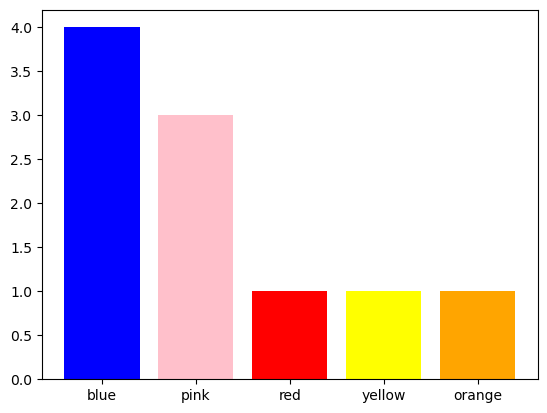

In [9]:
# barchart of sorted word counts
d = {'blue': counts_b['blue'], 'pink': counts_b['pink'], 'red': counts_b['red'], 'yellow': counts_b['yellow'], 'orange': counts_b['orange']}
plt.bar(range(len(d)), list(d.values()), align='center', color=d.keys())
_ = plt.xticks(range(len(d)), list(d.keys()))

### Napocitej pravdepodobnosti slov

Model je zalozeny na predikci nejpravdepodobnejsiho slova, takze je treba napocitat pravdepodobnosti slov:
$$
    P(w) = \frac{C(w)}{V}
$$
kde $ P(w) $ je pravdepodobnost slova, $V$ je velikost corpusu, $C(w)$ je pocet slov v nem.

O neco sofistikovanejsi je moznost pocitat dve slova po sobe jdouci a pouzit pak prvni slovo jak zjistit vyssi pravdepodbnost comba. Napriklad: jestli je "there friends" nebo "their friends" pravdepodobnejsi. 

#### LAB: String Edits Candidates

In [10]:
# data
word = 'dearz' # 🦌

In [11]:
# splits with a loop
splits_a = []
for i in range(len(word)+1):
    splits_a.append([word[:i],word[i:]])

for i in splits_a:
    print(i)

['', 'dearz']
['d', 'earz']
['de', 'arz']
['dea', 'rz']
['dear', 'z']
['dearz', '']


In [12]:
# same splits, done using a list comprehension
splits_b = [(word[:i], word[i:]) for i in range(len(word) + 1)]

for i in splits_b:
    print(i)

('', 'dearz')
('d', 'earz')
('de', 'arz')
('dea', 'rz')
('dear', 'z')
('dearz', '')


In [13]:
# Delete Edit
# deletes with a loop
splits = splits_a
deletes = []

print('word : ', word)
for L,R in splits:
    if R:
        print(L + R[1:], ' <-- delete ', R[0])

word :  dearz
earz  <-- delete  d
darz  <-- delete  e
derz  <-- delete  a
deaz  <-- delete  r
dear  <-- delete  z


In [14]:
# breaking it down
print('word : ', word)
one_split = splits[0]
print('first item from the splits list : ', one_split)
L = one_split[0]
R = one_split[1]
print('L : ', L)
print('R : ', R)
print('*** now implicit delete by excluding the leading letter ***')
print('L + R[1:] : ',L + R[1:], ' <-- delete ', R[0])

word :  dearz
first item from the splits list :  ['', 'dearz']
L :  
R :  dearz
*** now implicit delete by excluding the leading letter ***
L + R[1:] :  earz  <-- delete  d


In [15]:
# deletes with a list comprehension
splits = splits_a
deletes = [L + R[1:] for L, R in splits if R]

print(deletes)
print('*** which is the same as ***')
for i in deletes:
    print(i)

['earz', 'darz', 'derz', 'deaz', 'dear']
*** which is the same as ***
earz
darz
derz
deaz
dear


In [16]:
vocab = ['dean','deer','dear','fries','and','coke']
edits = list(deletes)

print('vocab : ', vocab)
print('edits : ', edits)

candidates=[]

### START CODE HERE ###
candidates = set.intersection(set(vocab), set(edits))
### END CODE HERE ###

print('candidate words : ', candidates)

vocab :  ['dean', 'deer', 'dear', 'fries', 'and', 'coke']
edits :  ['earz', 'darz', 'derz', 'deaz', 'dear']
candidate words :  {'dear'}


### Minimum Edit Distance

Je mira, ktera popisuje podobnost dvou stringu. Jedna se o aplikaci dynamickeho programovani. Do tabulky si zapisujeme zdrojove slovo a cilove slovo a ukladame do ni cenu ruznych uprav.

![image](./pomocne_soubory/dyn_prog.png)

Cena z # do # je 0.
Z P do # je 1, protoze je potreba smazat P.
Z # do P je 1, protoze je potreba pridat P.
Z P do P je 0, protoze neni potreba nic delat.
Z P do S je 2, protoze je potreba nahradit P za S (minimum cost z P do S).

Obecny vzorec na vypocet ceny je: 
$$
    D[i,j] = min \begin{cases}
        D[i-1,j] + del\_cost \\
        D[i,j-1] + ins\_cost \\
        D[i-1,j-1] + c
    \end{cases}       
$$
kde $D[i,j]$ je cena zmeny z i-teho znaku zdrojoveho slova na j-ty znak ciloveho slova, $del\_cost$ je cena smazani, 
$ins\_cost$ je cena pridani, a $c$: 

$$ 
    c = \begin{cases}
        0 & \text{ if } source[i] = target[j] \\
        rep\_cost & \text{ if } source[i] \neq target[j]
    \end{cases}
$$
a $rep\_cost$ je cena nahrazeni.

- $D[i,j] = D[i-1,j] + del\_cost$ oznacuje, ze po vypocet ceny na (i,j) v tabulce se pouzije cena z (i-1,j) a pricte se cena smazani.
- $D[i,j] = D[i,j-1] + ins\_cost$ oznacuje, ze po vypocet ceny na (i,j) v tabulce se pouzije cena z (i,j-1) a pricte se cena pridani.
- $D[i,j] = D[i-1,j-1] + c$ oznacuje, ze po vypocet ceny na (i,j) v tabulce se pouzije cena z (i-1,j-1) a pricte se $c$.

![image](./pomocne_soubory/dyn_prog_2.png)

Z obrazku je patrne, ze kdyz mame string "P" a chceme prazdny string, cena za smazeni je 1. Kdyz mame string "PL" a 
chceme prazdny string, cena za smazeni je 2. Kdyz mame string "PL" a chceme string "P", cena za smazeni je 1 a za 
dalsi smazani je taky 1. Analogicky pro pridavani stringu. Pro vyplneni bunky (1,1) je treba si spocitat cenu z
bunky (0,0) a pricist cenu za nahrazeni. Nebo si spocitat cenu z bunky (0,1), coz je string "P" a smazani "P" a k 
tomu pridat cenu za pridani "S". Nebo analogicky pro bunku (1,0). Vezmeme minumum z techto cisel, tj. 2. A takto
postupujeme pro vsechny bunky.

#### LAB: Assignment 1: Minimum Edit Distance

##### Exercise 1 - process_data
Implement the function `process_data` which 

1) Reads in a corpus (text file)

2) Changes everything to lowercase

3) Returns a list of words. 

##### Options and Hints
- If you would like more of a real-life practice, don't open the 'Hints' below (yet) and try searching the web to derive your answer.
- If you want a little help, click on the green "General Hints" section by clicking on it with your mouse.
- If you get stuck or are not getting the expected results, click on the green 'Detailed Hints' section to get hints for each step that you'll take to complete this function.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>General Hints</b></font>
</summary>
<p>
General Hints to get started
<ul>
    <li>Python <a href="https://docs.python.org/3/tutorial/inputoutput.html">input and output<a></li>
    <li>Python <a href="https://docs.python.org/3/library/re.html" >'re' documentation </a> </li>
</ul>
</p>


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Detailed Hints</b></font>
</summary>
<p>     
Detailed hints if you're stuck
<ul>
    <li>Use 'with' syntax to read a file</li>
    <li>Decide whether to use 'read()' or 'readline().  What's the difference?</li>
    <li>You can use str.lower() to convert to lowercase.</li>
    <li>Use re.findall(pattern, string)</li>
    <li>Look for the "Raw String Notation" section in the Python 're' documentation to understand the difference between r'\W', r'\W' and '\\W'. </li>
    <li>For the pattern, decide between using '\s', '\w', '\s+' or '\w+'.  What do you think are the differences?</li>
</ul>
</p>


In [25]:
def process_data(file_name):
    """
    Input: 
        A file_name which is found in your current directory. You just have to read it in. 
    Output: 
        words: a list containing all the words in the corpus (text file you read) in lower case. 
    """
    words = [] # return this variable correctly

    with open(file_name, 'r') as file:
        # Read the contents of the file
        text = file.read()
        # Convert text to lowercase
        text = text.lower()
        # Split text into words based on whitespace
        words = re.findall(r'\w+', text)
    
    return words

In [26]:
word_l = process_data('./pomocne_soubory/shakespeare.txt')
vocab = set(word_l)  # this will be your new vocabulary
print(f"The first ten words in the text are: \n{word_l[0:10]}")
print(f"There are {len(vocab)} unique words in the vocabulary.")

The first ten words in the text are: 
['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the']
There are 6116 unique words in the vocabulary.


##### Exercise 2 - get_count

Implement a `get_count` function that returns a dictionary
- The dictionary's keys are words
- The value for each word is the number of times that word appears in the corpus. 

For example, given the following sentence: **"I am happy because I am learning"**, your dictionary should return the following: 
<table style="width:20%">

  <tr>
    <td> <b>Key </b>  </td>
    <td> <b>Value </b> </td> 


  </tr>
  <tr>
    <td> I  </td>
    <td> 2</td> 
 
  </tr>
   
  <tr>
    <td>am</td>
    <td>2</td> 
  </tr>

  <tr>
    <td>happy</td>
    <td>1</td> 
  </tr>
  
   <tr>
    <td>because</td>
    <td>1</td> 
  </tr>
  
   <tr>
    <td>learning</td>
    <td>1</td> 
  </tr>
</table>


**Instructions**: 
Implement a `get_count` which returns a dictionary where the key is a word and the value is the number of times the word appears in the list.  


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>Try implementing this using a for loop and a regular dictionary. This may be good practice for similar coding interview questions</li>
    <li>You can also use defaultdict instead of a regular dictionary, along with the for loop</li>
    <li>Otherwise, to skip using a `for` loop, you can use Python's <a href="https://docs.python.org/3.7/library/collections.html#collections.Counter" > Counter class</a> </li>
</ul>
</p>

In [27]:
def get_count(word_l):
    '''
    Input:
        word_l: a set of words representing the corpus. 
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    
    word_count_dict = {}  # This will hold the word counts

    for word in word_l:
        if word in word_count_dict:
            word_count_dict[word] += 1  # Increment the count of the word
        else:
            word_count_dict[word] = 1   # Add the word with a count of 1 if it's not already in the dictionary

    return word_count_dict

In [28]:
word_count_dict = get_count(word_l)
print(f"There are {len(word_count_dict)} key values pairs")
print(f"The count for the word 'thee' is {word_count_dict.get('thee',0)}")

There are 6116 key values pairs
The count for the word 'thee' is 240


##### Exercise 3 - get_probs
Given the dictionary of word counts, compute the probability that each word will appear if randomly selected from the corpus of words.

$$P(w_i) = \frac{C(w_i)}{M} \tag{Eqn-2}$$
where 

$C(w_i)$ is the total number of times $w_i$ appears in the corpus.

$M$ is the total number of words in the corpus.

For example, the probability of the word 'am' in the sentence **'I am happy because I am learning'** is:

$$P(am) = \frac{C(w_i)}{M} = \frac {2}{7} \tag{Eqn-3}.$$

**Instructions:** Implement `get_probs` function which gives you the probability 
that a word occurs in a sample. This returns a dictionary where the keys are words, and the value for each word is its probability in the corpus of words.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
General advice
<ul>
    <li> Use dictionary.values() </li>
    <li> Use sum() </li>
    <li> The cardinality (number of words in the corpus should be equal to len(word_l).  You will calculate this same number, but using the word count dictionary.</li>
</ul>
    
If you're using a for loop:
<ul>
    <li> Use dictionary.keys() </li>
</ul>
    
If you're using a dictionary comprehension:
<ul>
    <li>Use dictionary.items() </li>
</ul>
</p>


In [29]:
def get_probs(word_count_dict):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur. 
    '''
    probs = {}  # return this variable correctly
    
    ### START CODE HERE ###
    M = sum(word_count_dict.values())

    # Calculate the probability for each word
    for word, count in word_count_dict.items():
        probs[word] = count / M
    ### END CODE HERE ###
    return probs

In [30]:
probs = get_probs(word_count_dict)
print(f"Length of probs is {len(probs)}")
print(f"P('thee') is {probs['thee']:.4f}")

Length of probs is 6116
P('thee') is 0.0045


##### 2 - String Manipulations

Now that you have computed $P(w_i)$ for all the words in the corpus, you will write a few functions to manipulate strings so that you can edit the erroneous strings and return the right spellings of the words. In this section, you will implement four functions: 

* `delete_letter`: given a word, it returns all the possible strings that have **one character removed**. 
* `switch_letter`: given a word, it returns all the possible strings that have **two adjacent letters switched**.
* `replace_letter`: given a word, it returns all the possible strings that have **one character replaced by another different letter**.
* `insert_letter`: given a word, it returns all the possible strings that have an **additional character inserted**. 


##### Exercise 4 - delete_letter

**Instructions for delete_letter():** Implement a `delete_letter()` function that, given a word, returns a list of strings with one character deleted. 

For example, given the word **nice**, it would return the set: {'ice', 'nce', 'nic', 'nie'}. 

**Step 1:** Create a list of 'splits'. This is all the ways you can split a word into Left and Right: For example,   
'nice is split into : `[('', 'nice'), ('n', 'ice'), ('ni', 'ce'), ('nic', 'e'), ('nice', '')]`
This is common to all four functions (delete, replace, switch, insert).


**Step 2:** This is specific to `delete_letter`. Here, we are generating all words that result from deleting one character.  
This can be done in a single line with a list comprehension. You can make use of this type of syntax:  
`[f(a,b) for a, b in splits if condition]`  

For our 'nice' example you get: 
['ice', 'nce', 'nie', 'nic']

##### Levels of assistance

Try this exercise with these levels of assistance.  
- We hope that this will make it both a meaningful experience but also not a frustrating experience. 
- Start with level 1, then move onto level 2, and 3 as needed.

    - Level 1. Try to think this through and implement this yourself.
    - Level 2. Click on the "Level 2 Hints" section for some hints to get started.
    - Level 3. If you would prefer more guidance, please click on the "Level 3 Hints" cell for step by step instructions.
    
- If you are still stuck, look at the images in the "list comprehensions" section above.


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Level 3 Hints</b></font>
</summary>
<p>
<ul>
    <li>splits: Use array slicing, like my_str[0:2], to separate a string into two pieces.</li>
    <li>Do this in a loop or list comprehension, so that you have a list of tuples.
    <li> For example, "cake" can get split into "ca" and "ke". They're stored in a tuple ("ca","ke"), and the tuple is appended to a list.  We'll refer to these as L and R, so the tuple is (L,R)</li>
    <li>When choosing the range for your loop, if you input the word "cans" and generate the tuple  ('cans',''), make sure to include an if statement to check the length of that right-side string (R) in the tuple (L,R) </li>
    <li>deletes: Go through the list of tuples and combine the two strings together. You can use the + operator to combine two strings</li>
    <li>When combining the tuples, make sure that you leave out a middle character.</li>
    <li>Use array slicing to leave out the first character of the right substring.</li>
</ul>
</p>

In [32]:
def delete_letter(word, verbose=False):
    '''
    Input:
        word: the string/word for which you will generate all possible words 
                in the vocabulary which have 1 missing character
    Output:
        delete_l: a list of all possible strings obtained by deleting 1 character from word
    '''
    
    delete_l = []
    split_l = []

    split_l = [(word[:i], word[i+1:]) for i in range(len(word))]
    delete_l = [y[0] + y[1] for y in split_l]

    if verbose: print(f"input word {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")
    return  delete_l

In [33]:
delete_word_l = delete_letter(word="cans", verbose=True)

input word cans, 
split_l = [('', 'ans'), ('c', 'ns'), ('ca', 's'), ('can', '')], 
delete_l = ['ans', 'cns', 'cas', 'can']


##### Note 1
- Notice how it has the extra tuple `('cans', '')`.
- This will be fine as long as you have checked the size of the right-side substring in tuple (L,R).
- Can you explain why this will give you the same result for the list of deletion strings (delete_l)?

```CPP
input word cans, 
split_l = [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's'), ('cans', '')], 
delete_l = ['ans', 'cns', 'cas', 'can']
```

##### Note 2
If you end up getting the same word as your input word, like this:

```Python
input word cans, 
split_l = [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's'), ('cans', '')], 
delete_l = ['ans', 'cns', 'cas', 'can', 'cans']
```

- Check how you set the `range`.
- See if you check the length of the string on the right-side of the split.

In [34]:
print(f"Number of outputs of delete_letter('at') is {len(delete_letter('at'))}")

Number of outputs of delete_letter('at') is 2


##### Exercise 5 - switch_letter

**Instructions for switch_letter()**: Now implement a function that switches two letters in a word. It takes in a word and returns a list of all the possible switches of two letters **that are adjacent to each other**. 
- For example, given the word 'eta', it returns {'eat', 'tea'}, but does not return 'ate'.

**Step 1:** is the same as in delete_letter()  
**Step 2:** A list comprehension or for loop which forms strings by swapping adjacent letters. This is of the form:  
`[f(L,R) for L, R in splits if condition]`  where 'condition' will test the length of R in a given iteration. See below.

##### Levels of difficulty

Try this exercise with these levels of difficulty.  
- Level 1. Try to think this through and implement this yourself.
- Level 2. Click on the "Level 2 Hints" section for some hints to get started.
- Level 3. If you would prefer more guidance, please click on the "Level 3 Hints" cell for step by step instructions.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Level 3 Hints</b></font>
</summary>
<p>
<ul>
    <li>splits: Use array slicing, like my_str[0:2], to separate a string into two pieces.</li>
    <li>Splitting is the same as for delete_letter</li>
    <li>To perform the switch, go through the list of tuples and combine four strings together. You can use the + operator to combine strings</li>
    <li>The four strings will be the left substring from the split tuple, followed by the first (index 1) character of the right substring, then the zero-th character (index 0) of the right substring, and then the remaining part of the right substring.</li>
    <li>Unlike delete_letter, you will want to check that your right substring is at least a minimum length.  To see why, review the previous hint bullet point (directly before this one).</li>
</ul>
</p>

In [37]:
def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    ''' 
    
    switch_l = []
    split_l = []
    
    ### START CODE HERE ###
    split_l = [(word[:i], word[i:]) for i in range(1, len(word))]
    switch_l = [L[:-1] + R[0] + L[-1] + R[1:] for L,R in split_l]
    
    ### END CODE HERE ###
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}") 
    
    return switch_l

In [38]:
switch_word_l = switch_letter(word="eta", verbose=True)

Input word = eta 
split_l = [('e', 'ta'), ('et', 'a')] 
switch_l = ['tea', 'eat']


##### Note 1

You may get this:
```Python
Input word = eta 
split_l = [('', 'eta'), ('e', 'ta'), ('et', 'a'), ('eta', '')] 
switch_l = ['tea', 'eat']
```
- Notice how it has the extra tuple `('eta', '')`.
- This is also correct.
- Can you think of why this is the case?

##### Exercise 6 - replace_letter
**Instructions for replace_letter()**: Now implement a function that takes in a word and returns a list of strings with one **replaced letter** from the original word. 

**Step 1:** is the same as in `delete_letter()`

**Step 2:** A list comprehension or for loop which form strings by replacing letters.  This can be of the form:  
`[f(a,b,c) for a, b in splits if condition for c in string]`   Note the use of the second for loop.  
It is expected in this routine that one or more of the replacements will include the original word. For example, replacing the first letter of 'ear' with 'e' will return 'ear'.

**Step 3:** Remove the original input letter from the output.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>To remove a word from a list, first store its contents inside a set()</li>
    <li>Use set.discard('the_word') to remove a word in a set.  Using set.remove('the_word') throws a KeyError if the word does not exist in the set. </li>
</ul>
</p>


In [40]:
def replace_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word. 
    ''' 
    
    letters = 'abcdefghijklmnopqrstuvwxyz'
    
    replace_l = []
    split_l = []

    replace_set = set()  # Use a set to avoid duplicates
    
    # Step 1: Create splits
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    
    # Step 2: Replace letters
    for a, b in split_l:
        if b:  # Ensure there is something to replace
            for c in letters:
                if b[0] != c:  # Condition to ensure it's actually a replacement
                    replace_set.add(a + c + b[1:])

    # turn the set back into a list and sort it, for easier viewing
    replace_l = sorted(list(replace_set))
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l {replace_l}")   
    
    return replace_l

In [42]:
replace_l = replace_letter(word='can', verbose=True)

Input word = can 
split_l = [('', 'can'), ('c', 'an'), ('ca', 'n')] 
replace_l ['aan', 'ban', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz', 'cbn', 'ccn', 'cdn', 'cen', 'cfn', 'cgn', 'chn', 'cin', 'cjn', 'ckn', 'cln', 'cmn', 'cnn', 'con', 'cpn', 'cqn', 'crn', 'csn', 'ctn', 'cun', 'cvn', 'cwn', 'cxn', 'cyn', 'czn', 'dan', 'ean', 'fan', 'gan', 'han', 'ian', 'jan', 'kan', 'lan', 'man', 'nan', 'oan', 'pan', 'qan', 'ran', 'san', 'tan', 'uan', 'van', 'wan', 'xan', 'yan', 'zan']


##### Exercise 7 - insert_letter

**Instructions for insert_letter()**: Now implement a function that takes in a word and returns a list with a letter inserted at every offset.

**Step 1:** is the same as in `delete_letter()`

**Step 2:** This can be a list comprehension of the form:  
`[f(a,b,c) for a, b in splits if condition for c in string]`   

In [43]:
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    ''' 
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_l = []
    split_l = []
    
    ### START CODE HERE ###
    split_l = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    
    # Insert each letter of the alphabet into every split position
    insert_l = [a + c + b for a, b in split_l for c in letters]
    ### END CODE HERE ###
    
    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")
    
    return insert_l

In [44]:
insert_l = insert_letter('at', True)
print(f"Number of strings output by insert_letter('at') is {len(insert_l)}")

Input word at 
split_l = [('', 'at'), ('a', 't'), ('at', '')] 
insert_l = ['aat', 'bat', 'cat', 'dat', 'eat', 'fat', 'gat', 'hat', 'iat', 'jat', 'kat', 'lat', 'mat', 'nat', 'oat', 'pat', 'qat', 'rat', 'sat', 'tat', 'uat', 'vat', 'wat', 'xat', 'yat', 'zat', 'aat', 'abt', 'act', 'adt', 'aet', 'aft', 'agt', 'aht', 'ait', 'ajt', 'akt', 'alt', 'amt', 'ant', 'aot', 'apt', 'aqt', 'art', 'ast', 'att', 'aut', 'avt', 'awt', 'axt', 'ayt', 'azt', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz']
Number of strings output by insert_letter('at') is 78


##### 3 - Combining the Edits

Now that you have implemented the string manipulations, you will create two functions that, given a string, will return all the possible single and double edits on that string. These will be `edit_one_letter()` and `edit_two_letters()`.

##### 3.1 - Edit One Letter

<a name='ex-8'></a>
##### Exercise 8 - edit_one_letter

**Instructions**: Implement the `edit_one_letter` function to get all the possible edits that are one edit away from a word. The edits  consist of the replace, insert, delete, and optionally the switch operation. You should use the previous functions you have already implemented to complete this function. The 'switch' function  is a less common edit function, so its use will be selected by an "allow_switches" input argument.

Note that those functions return *lists* while this function should return a *python set*. Utilizing a set eliminates any duplicate entries.

In [45]:
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """
    
    edit_one_set = set()

    # Generate all possible words with one letter replaced
    replace_set = set(replace_letter(word))
    edit_one_set.update(replace_set)
    
    # Generate all possible words with one letter inserted
    insert_set = set(insert_letter(word))
    edit_one_set.update(insert_set)
    
    # Generate all possible words with one letter deleted
    delete_set = set(delete_letter(word))
    edit_one_set.update(delete_set)
    
    # Optionally generate all possible words with two adjacent letters switched
    if allow_switches:
        switch_set = set(switch_letter(word))
        edit_one_set.update(switch_set)
    
    # return this as a set and not a list
    return set(edit_one_set)

In [46]:
tmp_word = "at"
tmp_edit_one_set = edit_one_letter(tmp_word)
# turn this into a list to sort it, in order to view it
tmp_edit_one_l = sorted(list(tmp_edit_one_set))

print(f"input word {tmp_word} \nedit_one_l \n{tmp_edit_one_l}\n")
print(f"The type of the returned object should be a set {type(tmp_edit_one_set)}")
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

input word at 
edit_one_l 
['a', 'aa', 'aat', 'ab', 'abt', 'ac', 'act', 'ad', 'adt', 'ae', 'aet', 'af', 'aft', 'ag', 'agt', 'ah', 'aht', 'ai', 'ait', 'aj', 'ajt', 'ak', 'akt', 'al', 'alt', 'am', 'amt', 'an', 'ant', 'ao', 'aot', 'ap', 'apt', 'aq', 'aqt', 'ar', 'art', 'as', 'ast', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz', 'au', 'aut', 'av', 'avt', 'aw', 'awt', 'ax', 'axt', 'ay', 'ayt', 'az', 'azt', 'bat', 'bt', 'cat', 'ct', 'dat', 'dt', 'eat', 'et', 'fat', 'ft', 'gat', 'gt', 'hat', 'ht', 'iat', 'it', 'jat', 'jt', 'kat', 'kt', 'lat', 'lt', 'mat', 'mt', 'nat', 'nt', 'oat', 'ot', 'pat', 'pt', 'qat', 'qt', 'rat', 'rt', 'sat', 'st', 't', 'ta', 'tat', 'tt', 'uat', 'ut', 'vat', 'vt', 'wat', 'wt', 'xat', 'xt', 'yat', 'yt', 'zat', 'zt']

The type of the returned object should be a set <class 'set'>
Number of outputs from edit_one_letter('at') is 129


##### 3.2 - Edit Two Letters

<a name='ex-9'></a>
##### Exercise 9 - edit_two_letters

Now you can generalize this to implement to get two edits on a word. To do so, you would have to get all the possible edits on a single word and then for each modified word, you would have to modify it again. 

**Instructions**: Implement the `edit_two_letters` function that returns a set of words that are two edits away. Note that creating additional edits based on the `edit_one_letter` function may 'restore' some one_edits to zero or one edits. That is allowed here. This is accounted for in get_corrections.

In [47]:
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word 
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    
    edit_two_set = set()

    # Generate all possible words with one edit
    edit_one_set = edit_one_letter(word, allow_switches)
    
    # For each word in the edit_one_set, generate all possible words with another edit
    for word_one_edit in edit_one_set:
        edit_two_set.update(edit_one_letter(word_one_edit, allow_switches))  
    
    # return this as a set instead of a list
    return set(edit_two_set)

In [48]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_l = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_l)}")
print(f"First 10 strings {tmp_edit_two_l[:10]}")
print(f"Last 10 strings {tmp_edit_two_l[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Number of strings with edit distance of two: 2654
First 10 strings ['', 'a', 'aa', 'aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag']
Last 10 strings ['zv', 'zva', 'zw', 'zwa', 'zx', 'zxa', 'zy', 'zya', 'zz', 'zza']
The data type of the returned object should be a set <class 'set'>
Number of strings that are 2 edit distances from 'at' is 7154


##### 3.3 - Suggest Spelling Suggestions

Now you will use your `edit_two_letters` function to get a set of all the possible 2 edits on your word. You will then use those strings to get the most probable word you meant to type a.k.a your typing suggestion.

##### Exercise 10 - get_corrections
**Instructions**: Implement `get_corrections`, which returns a list of zero to n possible suggestion tuples of the form (word, probability_of_word). 

**Step 1:** Generate suggestions for a supplied word: You'll use the edit functions you have developed. The 'suggestion algorithm' should follow this logic: 
* If the word is in the vocabulary, suggest the word. 
* Otherwise, if there are suggestions from `edit_one_letter` that are in the vocabulary, use those. 
* Otherwise, if there are suggestions from `edit_two_letters` that are in the vocabulary, use those. 
* Otherwise, suggest the input word.*  
* The idea is that words generated from fewer edits are more likely than words with more edits.


Note: 
- Edits of two letters may 'restore' strings to either zero or one edit. This algorithm accounts for this by preferentially selecting lower distance edits first.

##### Short circuit
In Python, logical operations such as `and` and `or` have two useful properties. They can operate on lists and they have ['short-circuit' behavior](https://docs.python.org/3/library/stdtypes.html). Try these:

In [51]:
# example of logical operation on lists or sets
print( [] and ["a","b"] )
print( [] or ["a","b"] )
#example of Short circuit behavior
val1 =  ["Most","Likely"] or ["Less","so"] or ["least","of","all"]  # selects first, does not evalute remainder
print(val1)
val2 =  [] or [] or ["least","of","all"] # continues evaluation until there is a non-empty list
print(val2)

[]
['a', 'b']
['Most', 'Likely']
['least', 'of', 'all']


The logical `or` could be used to implement the suggestion algorithm very compactly. Alternately, if/elif/else constructs could be used.
 
**Step 2**: Create a 'best_words' dictionary where the 'key' is a suggestion and the 'value' is the probability of that word in your vocabulary. If the word is not in the vocabulary, assign it a probability of 0.

**Step 3**: Select the n best suggestions. There may be fewer than n.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>edit_one_letter and edit_two_letters return *python sets*. </li>
    <li> Sets have a handy <a href="https://docs.python.org/2/library/sets.html" > set.intersection </a> feature</li>
    <li>To find the keys that have the highest values in a dictionary, you can use the Counter dictionary to create a Counter object from a regular dictionary.  Then you can use Counter.most_common(n) to get the n most common keys.
    </li>
    <li>To find the intersection of two sets, you can use set.intersection or the & operator.</li>
    <li>If you are not as familiar with short circuit syntax (as shown above), feel free to use if else statements instead.</li>
    <li>To use an if statement to check of a set is empty, use 'if not x:' syntax </li>
</ul>
</p>


In [52]:
def get_corrections(word, probs, vocab, n=2, verbose = False):
    '''
    Input: 
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output: 
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''
    
    suggestions = []
    n_best = []

    # If the word is in the vocabulary, suggest the word
    if word in vocab:
        suggestions = [(word, probs[word])]
    
    # Otherwise, if there are suggestions from edit_one_letter that are in the vocabulary, use those
    else:
        edit_one_set = edit_one_letter(word)
        edit_one_suggestions = [(w, probs[w]) for w in edit_one_set if w in vocab]
        suggestions = edit_one_suggestions or suggestions
    
    # Otherwise, if there are suggestions from edit_two_letters that are in the vocabulary, use those
    if not suggestions:
        edit_two_set = edit_two_letters(word)
        edit_two_suggestions = [(w, probs[w]) for w in edit_two_set if w in vocab]
        suggestions = edit_two_suggestions or suggestions
    
    # Otherwise, suggest the input word
    if not suggestions:
        suggestions = [(word, 0)]
    
    # Get the n best suggestions based on probability
    n_best = sorted(suggestions, key=lambda x: x[1], reverse=True)[:n]

    if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return n_best

In [53]:
# Test your implementation - feel free to try other words in my word
my_word = 'dys' 
tmp_corrections = get_corrections(my_word, probs, vocab, 2, verbose=True) # keep verbose=True
for i, word_prob in enumerate(tmp_corrections):
    print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")

# CODE REVIEW COMMENT: using "tmp_corrections" insteads of "cors". "cors" is not defined
print(f"data type of corrections {type(tmp_corrections)}")

entered word =  dys 
suggestions =  [('dye', 1.865184466743761e-05), ('days', 0.0004103405826836274)]
word 0: days, probability 0.000410
word 1: dye, probability 0.000019
data type of corrections <class 'list'>


##### 4 - Minimum Edit Distance

Now that you have implemented your auto-correct, how do you evaluate the similarity between two strings? For example: 'waht' and 'what'

Also how do you efficiently find the shortest path to go from the word, 'waht' to the word 'what'?

You will implement a dynamic programming system that will tell you the minimum number of edits required to convert a string into another string.

#### 4.1 - Dynamic Programming

Dynamic Programming breaks a problem down into subproblems which can be combined to form the final solution. Here, given a string source[0..i] and a string target[0..j], we will compute all the combinations of substrings[i, j] and calculate their edit distance. To do this efficiently, we will use a table to maintain the previously computed substrings and use those to calculate larger substrings.

You have to create a matrix and update each element in the matrix as follows:  

The diagram below describes how to initialize the table. Each entry in D[i,j] represents the minimum cost of converting string source[0:i] to string target[0:j]. The first column is initialized to represent the cumulative cost of deleting the source characters to convert string "EER" to "". The first row is initialized to represent the cumulative cost of inserting the target characters to convert from "" to "NEAR".

![image](./pomocne_soubory/EditDistInit4.png)    

![image](./pomocne_soubory/EditDistExample1.png)    

#### Exercise 11 - min_edit_distance

Again, the word "substitution" appears in the figure, but think of this as "replacement".

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li>The range(start, stop, step) function excludes 'stop' from its output</li>
    <li><a href="" > words </a> </li>
</ul>
</p>


In [59]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: a string corresponding to the string you are starting with
        target: a string corresponding to the string you want to end with
        ins_cost: an integer setting the insert cost
        del_cost: an integer setting the delete cost
        rep_cost: an integer setting the replace cost
    Output:
        D: a matrix of len(source)+1 by len(target)+1 containing minimum edit distances
        med: the minimum edit distance (med) required to convert the source string to the target
    '''
    # use deletion and insert cost as  1
    m = len(source) 
    n = len(target) 
    #initialize cost matrix with zeros and dimensions (m+1,n+1) 
    D = np.zeros((m+1, n+1), dtype=int) 

    # Fill in column 0, from row 1 to row m, both inclusive
    for row in range(1, m+1):
        D[row, 0] = row * del_cost  # cost of deleting characters from source
        
    # Fill in row 0, for all columns from 1 to n, both inclusive
    for col in range(1, n+1):
        D[0, col] = col * ins_cost  # cost of inserting characters to match target
        
    # Loop through row 1 to row m, both inclusive
    for row in range(1, m+1):
        
        # Loop through column 1 to column n, both inclusive
        for col in range(1, n+1):
            
            # Initialize r_cost to the 'replace' cost that is passed into this function
            r_cost = rep_cost
            
            # Check to see if source character at the previous row
            # matches the target character at the previous column
            if source[row-1] == target[col-1]:
                # Update the replacement cost to 0 if source and target are the same
                r_cost = 0
                
            # Update the cost at row, col based on previous entries in the cost matrix
            # Refer to the equation to calculate for D[row, col] (the minimum of three calculated costs)
            D[row, col] = min(D[row-1, col] + del_cost,   # Deletion
                              D[row, col-1] + ins_cost,   # Insertion
                              D[row-1, col-1] + r_cost)  # Replacement or no change
            
    # Set the minimum edit distance with the cost found at row m, column n 
    med = D[m, n]
    
    return D, med

In [60]:
# testing your implementation 
source =  'play'
target = 'stay'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  4 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4


In [61]:
# testing your implementation 
source =  'eer'
target = 'near'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list(source)
idx.insert(0, '#')
cols = list(target)
cols.insert(0, '#')
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  3 

   #  n  e  a  r
#  0  1  2  3  4
e  1  2  1  2  3
e  2  3  2  3  4
r  3  4  3  4  3


In [62]:
source = "eer"
targets = edit_one_letter(source,allow_switches = False)  #disable switches since min_edit_distance does not include them
for t in targets:
    _, min_edits = min_edit_distance(source, t,1,1,1)  # set ins, del, sub costs all to one
    if min_edits != 1: print(source, t, min_edits)

Expected Results
(empty)
The 'replace()' routine utilizes all letters a-z one of which returns the original word.

In [63]:
source = "eer"
targets = edit_two_letters(source,allow_switches = False) #disable switches since min_edit_distance does not include them
for t in targets:
    _, min_edits = min_edit_distance(source, t,1,1,1)  # set ins, del, sub costs all to one
    if min_edits != 2 and min_edits != 1: print(source, t, min_edits)

eer eer 0


##### 5 - Backtrace (Optional)

In [65]:
def backtrace(matrix, source, target, i, j):
    if i == 0 and j == 0:
        return []
    elif i == 0:
        return [f"INSERT {target[j-1]}"] + backtrace(matrix, source, target, i, j-1)
    elif j == 0:
        return [f"DELETE {source[i-1]}"] + backtrace(matrix, source, target, i-1, j)
    else:
        if matrix[i][j] == matrix[i-1][j-1] and source[i-1] == target[j-1]:
            return [f"KEEP {source[i-1]}"] + backtrace(matrix, source, target, i-1, j-1)
        elif matrix[i][j] == matrix[i-1][j-1] + 1:
            return [f"REPLACE {source[i-1]} with {target[j-1]}"] + backtrace(matrix, source, target, i-1, j-1)
        elif matrix[i][j] == matrix[i-1][j] + 1:
            return [f"DELETE {source[i-1]}"] + backtrace(matrix, source, target, i-1, j)
        else:
            return [f"INSERT {target[j-1]}"] + backtrace(matrix, source, target, i, j-1)

## Part of Speech Tagging and Hidden Markov Models

Part of Speech Tagging (POS) je proces, kdy kazdemu slovu priradime nejaky "part of speech", jako je podstatne jmeno, sloveso, atp. Jeden z moznych modelu jsou markovske processy, hidden markov chains a Viterbi Algoritmus. 

POS se pouziva k taggovani 
- jmen,
- speech recognition,
- coreference resolution (na co ukazuji zajmena ve vete). 

### LAB: POS, Prace se textem

In [3]:
# Read lines from 'WSJ_02-21.pos' file and save them into the 'lines' variable
with open("./pomocne_soubory/WSJ_02-21.pos", 'r') as f:
    lines = f.readlines()

In [5]:
# Print columns for reference
print("\t\tWord", "\tTag\n")

# Print first five lines of the dataset
for i in range(5):
    print(f'line number {i+1}: {lines[i]}')

		Word 	Tag

line number 1: In	IN

line number 2: an	DT

line number 3: Oct.	NNP

line number 4: 19	CD

line number 5: review	NN



Vyznam zkratek pro Tag je mozne najit [here](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html).

In [6]:
# Print first line (unformatted)
lines[0]

'In\tIN\n'

Indeed there is a tab between the word and the tag and a newline at the end of each line.

#### Creating a vocabulary

Now that you understand how the dataset is structured, you will create a vocabulary out of it. A vocabulary is made up of every word that appeared at least 2 times in the dataset. 
For this, follow these steps:
- Get only the words from the dataset
- Use a defaultdict to count the number of times each word appears
- Filter the dict to only include words that appeared at least 2 times
- Create a list out of the filtered dict
- Sort the list

For step 1 you can use the fact that every word and tag are separated by a tab and that words always come first. Using list comprehension the words list can be created like this:

In [7]:
# Get the words from each line in the dataset
words = [line.split('\t')[0] for line in lines]

Step 2 can be done easily by leveraging `defaultdict`. In case you aren't familiar with defaultdicts they are a special kind of dictionaries that **return the "zero" value of a type if you try to access a key that does not exist**. Since you want the frequencies of words, you should define the defaultdict with a type of `int`. 

In [8]:
# Define defaultdict of type 'int'
freq = defaultdict(int)

# Count frequency of ocurrence for each word in the dataset
for word in words:
    freq[word] += 1

In [9]:
# Create the vocabulary by filtering the 'freq' dictionary
vocab = [k for k, v in freq.items() if (v > 1 and k != '\n')]

In [10]:
# Sort the vocabulary
vocab.sort()

# Print some random values of the vocabulary
for i in range(4000, 4005):
    print(vocab[i])

Early
Earnings
Earth
Earthquake
East


#### Processing new text sources
##### Dealing with unknown words

Now that you have a vocabulary, you will use it when processing new text sources. **A new text will have words that do not appear in the current vocabulary**. To tackle this, you can simply classify each new word as an unknown one, but you can do better by creating a function that tries to classify the type of each unknown word and assign it a corresponding `unknown token`. 

This function will do the following checks and return an appropriate token:

   - Check if the unknown word contains any character that is a digit 
       - return `--unk_digit--`
   - Check if the unknown word contains any punctuation character 
       - return `--unk_punct--`
   - Check if the unknown word contains any upper-case character 
       - return `--unk_upper--`
   - Check if the unknown word ends with a suffix that could indicate it is a noun, verb, adjective or adverb 
        - return `--unk_noun--`, `--unk_verb--`, `--unk_adj--`, `--unk_adv--` respectively

If a word fails to fall under any condition then its token will be a plain `--unk--`. The conditions will be evaluated in the same order as listed here. So if a word contains a punctuation character but does not contain digits, it will fall under the second condition. To achieve this behaviour some if/elif statements can be used along with early returns. 

This function is implemented next. Notice that the `any()` function is being heavily used. It returns `True` if at least one of the cases it evaluates is `True`.

In [11]:
def assign_unk(word):
    """
    Assign tokens to unknown words
    """
    
    # Punctuation characters
    # Try printing them out in a new cell!
    punct = set(string.punctuation)
    
    # Suffixes
    noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
    verb_suffix = ["ate", "ify", "ise", "ize"]
    adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
    adv_suffix = ["ward", "wards", "wise"]

    # Loop the characters in the word, check if any is a digit
    if any(char.isdigit() for char in word):
        return "--unk_digit--"

    # Loop the characters in the word, check if any is a punctuation character
    elif any(char in punct for char in word):
        return "--unk_punct--"

    # Loop the characters in the word, check if any is an upper case character
    elif any(char.isupper() for char in word):
        return "--unk_upper--"

    # Check if word ends with any noun suffix
    elif any(word.endswith(suffix) for suffix in noun_suffix):
        return "--unk_noun--"

    # Check if word ends with any verb suffix
    elif any(word.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"

    # Check if word ends with any adjective suffix
    elif any(word.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"

    # Check if word ends with any adverb suffix
    elif any(word.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"
    
    # If none of the previous criteria is met, return plain unknown
    return "--unk--"


##### Getting the correct tag for a word

All that is left is to implement a function that will get the correct tag for a particular word taking special considerations for unknown words. Since the dataset provides each word and tag within the same line and a word being known depends on the vocabulary used, these two elements should be arguments to this function.

This function should check if a line is empty and if so, it should return a placeholder word and tag, `--n--` and `--s--` respectively. 

If not, it should process the line to return the correct word and tag pair, considering if a word is unknown in which scenario the function `assign_unk()` should be used.

The function is implemented next. Notice that the `split()` method can be used without specifying the delimiter, in which case it will default to any whitespace.

In [12]:
def get_word_tag(line, vocab):
    # If line is empty return placeholders for word and tag
    if not line.split():
        word = "--n--"
        tag = "--s--"
    else:
        # Split line to separate word and tag
        word, tag = line.split()
        # Check if word is not in vocabulary
        if word not in vocab: 
            # Handle unknown word
            tag = assign_unk(word)
    return word, tag

In [13]:
get_word_tag('\n', vocab)

('--n--', '--s--')

In [14]:
get_word_tag('In\tIN\n', vocab)

('In', 'IN')

In [15]:
get_word_tag('tardigrade\tNN\n', vocab)

('tardigrade', '--unk--')

In [16]:
get_word_tag('scrutinize\tVB\n', vocab)

('scrutinize', '--unk_verb--')

### Markovsky Retezce

Tady asi neni poradne o cem. Proste klasicky markovsky retezce. Stavovy prostor, prechazi se mezi stavy pomoci matice prechodu.

!<img src="./pomocne_soubory/markov_chains.png"  width="920">

Skryte maarkovske procesy se lisi tim, ze maji jeste jednu vrstvu, kterou pozorujeme, tzv. emission probabilities. 
Transition probabilities nevidime a nemuzeme je pozorovat. Nejcasteji se parametry modelu odhaduji pomoci maximalni 
verohodnosti.

!<img src="./pomocne_soubory/hidden_mc_1.png"  width="920">
!<img src="./pomocne_soubory/hidden_mc_2.png"  width="720">

Vzhledem k tomu, ze Markovsky retezec je zalozeny na predpokladu, ze soucasny stav $t_i$ zavisi jen na predcozim 
stavu v case $t_{i-1}$, tak potrebujeme napocitat pravdepodobnostni distribuci pro vsechny stavy $t_i$ v zavislosti na
vsech predchozich stavech $t_{i-1}$. Tuto distribuci muzeme zapsat jako:
$$P(t_i|t_{i-1}, t_{i-2}, ..., t_1) = P(t_i|t_{i-1})$$
Tuto distribuci muzeme zapsat jako matici prechodu $A$, kde $A_{ij} = P(t_j|t_i)$.
Pravdepodobnosti prechodu $A$ muzeme odhadnout pomoci maximalni verohodnosti. V nasem pripade pak 
$$ P(t_i|t_{i-1}) = 
\frac{C(t_{i-1}, t_i)} {\sum_{j=1}^N C(t_{i-1}, t_j))}
$$
kde $C(t_{i-1}, t_i)$ je pocet prechodu kolikrat se tag $t_{i-1}$ objevil pred tagem $t_i$ a $\sum_{j=1}^N C(t_{i-1},
 t_j) = C(t_{i-1})$ je pocet vyskytu tagu $t_{i-1}$.

Abychom se vyhli problemum, kdy pro nejakou pripad $t_{i-1, i}$ nebyl v trenovacim datasetu, tak se pouziva Laplace 
smoothing, kdy se ke kazdemu $C(t_{i-1}, t_i)$ pricita male $\epsilon$. Vysledny vzorec pak vypada:
$$ P(t_i|t_{i-1}) =
\frac{C(t_{i-1}, t_i) + \epsilon} {\sum_{j=1}^N C(t_{i-1}, t_j) + \epsilon \cdot N}
$$

Analogicky se pak vypocitava matice emisi $B$, kde $B_{ij} = P(w_j|t_i)$, kde $w_j$ je slovo a $t_i$ je tag. Vysledny vzorec
pak vypada:
$$ P(w_j|t_i) =
\frac{C(t_i, w_j) + \epsilon} {\sum_{j=1}^N C(t_i, w_j) + \epsilon \cdot N} = 
\frac{C(t_i, w_j) + \epsilon} {C(t_i) + \epsilon \cdot V}
$$

### LAB: Parts-of-Speech Tagging with Hidden Markov Models

In [68]:
# Define tags for Adverb, Noun and To (the preposition) , respectively
tags = ['RB', 'NN', 'TO']

In [69]:
# Define 'transition_counts' dictionary
# Note: values are the same as the ones in the assignment
transition_counts = {
    ('NN', 'NN'): 16241,
    ('RB', 'RB'): 2263,
    ('TO', 'TO'): 2,
    ('NN', 'TO'): 5256,
    ('RB', 'TO'): 855,
    ('TO', 'NN'): 734,
    ('NN', 'RB'): 2431,
    ('RB', 'NN'): 358,
    ('TO', 'RB'): 200
}

In [72]:
# Store the number of tags in the 'num_tags' variable
num_tags = len(tags)

# Initialize a 3X3 numpy array with zeros
transition_matrix = np.zeros((num_tags, num_tags))

# Print matrix
transition_matrix

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [73]:
# Print shape of the matrix
transition_matrix.shape

(3, 3)

In [74]:
# Create sorted version of the tag's list
sorted_tags = sorted(tags)

# Print sorted list
sorted_tags

['NN', 'RB', 'TO']

In [75]:
# Loop rows
for i in range(num_tags):
    # Loop columns
    for j in range(num_tags):
        # Define tag pair
        tag_tuple = (sorted_tags[i], sorted_tags[j])
        # Get frequency from transition_counts dict and assign to (i, j) position in the matrix
        transition_matrix[i, j] = transition_counts.get(tag_tuple)

# Print matrix
transition_matrix

array([[1.6241e+04, 2.4310e+03, 5.2560e+03],
       [3.5800e+02, 2.2630e+03, 8.5500e+02],
       [7.3400e+02, 2.0000e+02, 2.0000e+00]])

In [76]:
# Define 'print_matrix' function
def print_matrix(matrix):
    print(pd.DataFrame(matrix, index=sorted_tags, columns=sorted_tags))

In [77]:
# Print the 'transition_matrix' by calling the 'print_matrix' function
print_matrix(transition_matrix)

         NN      RB      TO
NN  16241.0  2431.0  5256.0
RB    358.0  2263.0   855.0
TO    734.0   200.0     2.0


In [78]:
# Compute sum of row for each row
rows_sum = transition_matrix.sum(axis=1, keepdims=True)

# Print sum of rows
rows_sum

array([[23928.],
       [ 3476.],
       [  936.]])

In [79]:
# Normalize transition matrix
transition_matrix = transition_matrix / rows_sum

# Print normalized matrix
print_matrix(transition_matrix)

          NN        RB        TO
NN  0.678745  0.101596  0.219659
RB  0.102992  0.651036  0.245972
TO  0.784188  0.213675  0.002137


In [80]:
transition_matrix.sum(axis=1, keepdims=True)

array([[1.],
       [1.],
       [1.]])

In [82]:
# Copy transition matrix for for-loop example
t_matrix_for = np.copy(transition_matrix)

# Copy transition matrix for numpy functions example
t_matrix_np = np.copy(transition_matrix)

In [83]:
# Loop values in the diagonal
for i in range(num_tags):
    t_matrix_for[i, i] =  t_matrix_for[i, i] + math.log(rows_sum[i])

# Print matrix
print_matrix(t_matrix_for)

           NN        RB        TO
NN  10.761549  0.101596  0.219659
RB   0.102992  8.804673  0.245972
TO   0.784188  0.213675  6.843752


/var/folders/tf/tzhjhrlj1_x14gcsq_wsn4580000gn/T/ipykernel_76077/158205974.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t_matrix_for[i, i] =  t_matrix_for[i, i] + math.log(rows_sum[i])


In [84]:
# Save diagonal in a numpy array
d = np.diag(t_matrix_np)

# Print shape of diagonal
d.shape

(3,)

In [85]:
# Reshape diagonal numpy array
d = np.reshape(d, (3,1))

# Print shape of diagonal
d.shape

(3, 1)

In [86]:
# Perform the vectorized operation
d = d + np.vectorize(math.log)(rows_sum)

# Use numpy's 'fill_diagonal' function to update the diagonal
np.fill_diagonal(t_matrix_np, d)

# Print the matrix
print_matrix(t_matrix_np)

           NN        RB        TO
NN  10.761549  0.101596  0.219659
RB   0.102992  8.804673  0.245972
TO   0.784188  0.213675  6.843752


In [87]:
# Check for equality
t_matrix_for == t_matrix_np

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

### Viterbi Algorithm

Viterbiho algoritmus je dynamicky programovaci algoritmus, ktery se pouziva k nalezeni nejpravdepodobnejsi 
posloupnosti skrytych stavu (take zvana Viterbiho cesta), ktera vede k posloupnosti pozorovanych udalosti, zejmena v
 kontextu skrytych Markovovych modelu (HMM). Tento algoritmus je siroce pouzivan v ruznych aplikacich, jako je 
 rozpoznavani reci, bioinformatika a dekodovani konvolucnich kodu. 
V nasem pripade budeme pouzivat Viterbiho algoritmus k tagovani slov v textu. 
Zjednodusene: napocitavame pravdepoodbnosti prechodu pro kazde pozorovane slovo a ukladame si indexy tagu z kterych 
jdeme. A zaroven si ukladame indexy tagu z kterych jdeme. Jakmile mame plnou matici vezmeme nejpravdepodonejsi cestu 
a vracime se pres indexy v D matici, abychom nasli tagy vsech predchozich slov. 
Ilustrativne zde: https://www.coursera.org/learn/probabilistic-models-in-nlp/supplement/9BigR/viterbi-forward-pass a 
tady: https://www.coursera.org/learn/probabilistic-models-in-nlp/supplement/4OAHP/viterbi-backward-pass.


The Viterbi algorithm is a dynamic programming algorithm used to find the most probable sequence of hidden states 
(also known as the Viterbi path) that results in a sequence of observed events, especially in the context of Hidden Markov Models (HMMs). This algorithm is widely used in various applications such as speech recognition, bioinformatics, and decoding of convolutional codes.

#### Key Components of the Viterbi Algorithm

1. **States**: $ S = \{s_1, s_2, \ldots, s_N\} $ - Set of possible states in the HMM.
2. **Observations**: $ O = \{o_1, o_2, \ldots, o_T\} $ - Sequence of observed events.
3. **Initial Probabilities**: $ \pi = \{\pi_i\} $ where $ \pi_i $ is the probability of starting in state $ s_i $.
4. **Transition Probabilities**: $ A = \{a_{ij}\} $ where $ a_{ij} $ is the probability of transitioning from state $ s_i $ to state $ s_j $.
5. **Emission Probabilities**: $ B = \{b_j(o_t)\} $ where $ b_j(o_t) $ is the probability of observing $ o_t $ from state $ s_j $.

#### Viterbi Algorithm Steps

1. **Initialization**:
    For each state $ s_i $:
    $$
    \delta_1(i) = \pi_i b_i(o_1)
    $$
    $$
    \psi_1(i) = 0
    $$
Where $ \delta_1(i) $ is the highest probability of any path that reaches state $ s_i $ at time $ t = 1 $, and $ \psi_1(i) $ is the backpointer to reconstruct the path.

2. **Recursion**:
    For each time step $ t = 2, 3, \ldots, T $:
    For each state $ s_j $:
    $$
    \delta_t(j) = \max_{i} [\delta_{t-1}(i) a_{ij}] b_j(o_t)
    $$
    $$
    \psi_t(j) = \arg\max_{i} [\delta_{t-1}(i) a_{ij}]
    $$
Where $ \delta_t(j) $ is the highest probability of any path that reaches state $ s_j $ at time $ t $, and $ \psi_t(j) $ is the backpointer.

3. **Termination**:
    $$
    P^* = \max_{i} [\delta_T(i)]
    $$
    $$
    q_T^* = \arg\max_{i} [\delta_T(i)]
    $$
Where $ P^* $ is the highest probability of the most probable path, and $ q_T^* $ is the final state of this path.

4. **Path Backtracking**:
    For $ t = T-1, T-2, \ldots, 1 $:
    $$
    q_t^* = \psi_{t+1}(q_{t+1}^*)
    $$
This step reconstructs the most probable path by backtracking from the final state.

#### Example Illustration

Suppose we have an HMM with 2 states (Rainy and Sunny) and 3 possible observations (Walk, Shop, Clean). Let:

- Initial probabilities: $ \pi = \{0.6, 0.4\} $ (for Rainy and Sunny respectively)
- Transition matrix:
  $$
  A = \begin{bmatrix}
  0.7 & 0.3 \\
  0.4 & 0.6
  \end{bmatrix}
  $$
- Emission matrix:
  $$
  B = \begin{bmatrix}
  0.1 & 0.4 & 0.5 \\
  0.6 & 0.3 & 0.1
  \end{bmatrix}
  $$

If we observe the sequence $ O = \{Walk, Shop, Clean\} $:

1. **Initialization**:
    $$
    \delta_1(Rainy) = \pi_1 \cdot b_1(Walk) = 0.6 \cdot 0.1 = 0.06
    $$
    $$
    \delta_1(Sunny) = \pi_2 \cdot b_2(Walk) = 0.4 \cdot 0.6 = 0.24
    $$

2. **Recursion for $ t = 2 $**:
    $$
    \delta_2(Rainy) = \max[ \delta_1(Rainy) \cdot a_{11}, \delta_1(Sunny) \cdot a_{21} ] \cdot b_1(Shop)
    $$
    $$
    \delta_2(Rainy) = \max[ 0.06 \cdot 0.7, 0.24 \cdot 0.4 ] \cdot 0.4 = 0.0384
    $$
    $$
    \delta_2(Sunny) = \max[ \delta_1(Rainy) \cdot a_{12}, \delta_1(Sunny) \cdot a_{22} ] \cdot b_2(Shop)
    $$
    $$
    \delta_2(Sunny) = \max[ 0.06 \cdot 0.3, 0.24 \cdot 0.6 ] \cdot 0.3 = 0.0432
    $$

3. **Recursion for $ t = 3 $**:
    $$
    \delta_3(Rainy) = \max[ \delta_2(Rainy) \cdot a_{11}, \delta_2(Sunny) \cdot a_{21} ] \cdot b_1(Clean)
    $$
    $$
    \delta_3(Rainy) = \max[ 0.0384 \cdot 0.7, 0.0432 \cdot 0.4 ] \cdot 0.5 = 0.01344
    $$
    $$
    \delta_3(Sunny) = \max[ \delta_2(Rainy) \cdot a_{12}, \delta_2(Sunny) \cdot a_{22} ] \cdot b_2(Clean)
    $$
    $$
    \delta_3(Sunny) = \max[ 0.0384 \cdot 0.3, 0.0432 \cdot 0.6 ] \cdot 0.1 = 0.002592
    $$

4. **Termination**:
    $$
    P^* = \max[ \delta_3(Rainy), \delta_3(Sunny) ] = \max[ 0.01344, 0.002592 ] = 0.01344
    $$
    $$
    q_3^* = \arg\max[ \delta_3(Rainy), \delta_3(Sunny) ] = Rainy
    $$

5. **Path Backtracking**:
    $$
    q_2^* = \psi_3(Rainy) = Sunny \quad (since \delta_2(Sunny) \cdot a_{21} \cdot b_1(Clean) was the max path)
    $$
    $$
    q_1^* = \psi_2(Sunny) = Sunny \quad (since \delta_1(Sunny) \cdot a_{22} \cdot b_2(Shop) was the max path)
    $$

Thus, the most probable hidden state sequence for the observations $ \{Walk, Shop, Clean\} $ is $ \{Sunny, Sunny, Rainy\} $.

This explanation covers the essential steps and concepts involved in the Viterbi algorithm. If you have any specific questions or need further elaboration on any part, feel free to ask!

### LAB: Assignment 2: POS, HMM, Viterbi Algorithm

#### 0 - Data Sources
This assignment will use two tagged data sets collected from the **Wall Street Journal (WSJ)**. 

[Here](http://relearn.be/2015/training-common-sense/sources/software/pattern-2.6-critical-fork/docs/html/mbsp-tags.html) is an example 'tag-set' or Part of Speech designation describing the two or three letter tag and their meaning. 
- One data set (**WSJ-2_21.pos**) will be used for **training**.
- The other (**WSJ-24.pos**) for **testing**. 
- The tagged training data has been preprocessed to form a vocabulary (**hmm_vocab.txt**). 
- The words in the vocabulary are words from the training set that were used two or more times. 
- The vocabulary is augmented with a set of 'unknown word tokens', described below. 

The training set will be used to create the emission, transition and tag counts. 

The test set (WSJ-24.pos) is read in to create `y`. 
- This contains both the test text and the true tag. 
- The test set has also been preprocessed to remove the tags to form **test_words.txt**. 
- This is read in and further processed to identify the end of sentences and handle words not in the vocabulary using functions provided in **utils_pos.py**. 
- This forms the list `prep`, the preprocessed text used to test our  POS taggers.

A POS tagger will necessarily encounter words that are not in its datasets. 
- To improve accuracy, these words are further analyzed during preprocessing to extract available hints as to their appropriate tag. 
- For example, the suffix 'ize' is a hint that the word is a verb, as in 'final-ize' or 'character-ize'. 
- A set of unknown-tokens, such as '--unk-verb--' or '--unk-noun--' will replace the unknown words in both the training and test corpus and will appear in the emission, transition and tag data structures.


<img src = "pomocne_soubory/DataSources1.PNG" />

In [93]:
# load in the training corpus
with open("./pomocne_soubory/WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()

print(f"A few items of the training corpus list")
print(training_corpus[0:5])

A few items of the training corpus list
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [94]:
# read the vocabulary data, split by each line of text, and save the list
with open("./pomocne_soubory/hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

print("A few items of the vocabulary list")
print(voc_l[0:50])
print()
print("A few items at the end of the vocabulary list")
print(voc_l[-50:])

A few items of the vocabulary list
['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s", "'80s", "'86", "'90s", "'N", "'S", "'d", "'em", "'ll", "'m", "'n'", "'re", "'s", "'til", "'ve", '(', ')', ',', '-', '--', '--n--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', '...', '0.01', '0.0108', '0.02', '0.03', '0.05', '0.1', '0.10', '0.12', '0.13', '0.15']

A few items at the end of the vocabulary list
['yards', 'yardstick', 'year', 'year-ago', 'year-before', 'year-earlier', 'year-end', 'year-on-year', 'year-round', 'year-to-date', 'year-to-year', 'yearlong', 'yearly', 'years', 'yeast', 'yelled', 'yelling', 'yellow', 'yen', 'yes', 'yesterday', 'yet', 'yield', 'yielded', 'yielding', 'yields', 'you', 'young', 'younger', 'youngest', 'youngsters', 'your', 'yourself', 'youth', 'youthful', 'yuppie', 'yuppies', 'zero', 'zero-coupon', 'zeroing', 'zeros', 'zinc', 'zip', 'zombie', 'zone', 'zones', 'zoning', '{',

In [95]:
# vocab: dictionary that has the index of the corresponding words
vocab = {}

# Get the index of the corresponding words. 
for i, word in enumerate(sorted(voc_l)): 
    vocab[word] = i       
    
print("Vocabulary dictionary, key is the word, value is a unique integer")
cnt = 0
for k,v in vocab.items():
    print(f"{k}:{v}")
    cnt += 1
    if cnt > 20:
        break

Vocabulary dictionary, key is the word, value is a unique integer
:0
!:1
#:2
$:3
%:4
&:5
':6
'':7
'40s:8
'60s:9
'70s:10
'80s:11
'86:12
'90s:13
'N:14
'S:15
'd:16
'em:17
'll:18
'm:19
'n':20


In [96]:
# load in the test corpus
with open("./pomocne_soubory/WSJ_24.pos", 'r') as f:
    y = f.readlines()
    
print("A sample of the test corpus")
print(y[0:10])

A sample of the test corpus
['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [97]:
#corpus without tags, preprocessed
_, prep = preprocess(vocab, "./pomocne_soubory/test.words")     

print('The length of the preprocessed test corpus: ', len(prep))
print('This is a sample of the test_corpus: ')
print(prep[0:10])

The length of the preprocessed test corpus:  34199
This is a sample of the test_corpus: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


#### 1 - Parts-of-speech Tagging 

<a name='1.1'></a>
##### 1.1 - Training
You will start with the simplest possible parts-of-speech tagger and we will build up to the state of the art. 

In this section, you will find the words that are not ambiguous. 
- For example, the word `is` is a verb and it is not ambiguous. 
- In the `WSJ` corpus, $86$% of the token are unambiguous (meaning they have only one tag) 
- About $14\%$ are ambiguous (meaning that they have more than one tag)

##### Transition counts
- The first dictionary is the `transition_counts` dictionary which computes the number of times each tag happened next to another tag. 

This dictionary will be used to compute: 
$$P(t_i |t_{i-1}) \tag{1}$$

This is the probability of a tag at position $i$ given the tag at position $i-1$.

In order for you to compute equation 1, you will create a `transition_counts` dictionary where 
- The keys are `(prev_tag, tag)`
- The values are the number of times those two tags appeared in that order. 

##### Emission counts

The second dictionary you will compute is the `emission_counts` dictionary. This dictionary will be used to compute:

$$P(w_i|t_i)\tag{2}$$

In other words, you will use it to compute the probability of a word given its tag. 

In order for you to compute equation 2, you will create an `emission_counts` dictionary where 
- The keys are `(tag, word)` 
- The values are the number of times that pair showed up in your training set. 

##### Tag counts

The last dictionary you will compute is the `tag_counts` dictionary. 
- The key is the tag 
- The value is the number of times each tag appeared.

#### Exercise 1 - create_dictionaries

**Instructions:** Write a program that takes in the `training_corpus` and returns the three dictionaries mentioned above `transition_counts`, `emission_counts`, and `tag_counts`. 
- `emission_counts`: maps (tag, word) to the number of times it happened. 
- `transition_counts`: maps (prev_tag, tag) to the number of times it has appeared. 
- `tag_counts`: maps (tag) to the number of times it has occured. 

Implementation note: This routine utilises *defaultdict*, which is a subclass of *dict*. 
- A standard Python dictionary throws a *KeyError* if you try to access an item with a key that is not currently in the dictionary. 
- In contrast, the *defaultdict* will create an item of the type of the argument, in this case an integer with the default value of 0. 
- See [defaultdict](https://docs.python.org/3.3/library/collections.html#defaultdict-objects).

In [99]:
def create_dictionaries(training_corpus, vocab, verbose=True):
    """
    Input: 
        training_corpus: a corpus where each line has a word followed by its tag.
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output: 
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
        tag_counts: a dictionary where the keys are the tags and the values are the counts
    """
    
    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--' 
    
    # use 'i' to track the line number in the corpus
    i = 0 
    
    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:
        
        # Increment the word_tag count
        i += 1
        
        # Every 50,000 words, print the word count
        if i % 50000 == 0 and verbose:
            print(f"word count = {i}")
        # get the word and tag using the get_word_tag helper function (imported from utils_pos.py)
        # the function is defined as: get_word_tag(line, vocab)
        word, tag = get_word_tag(word_tag, vocab)
        
        # Increment the transition count for the previous word and tag
        transition_counts[(prev_tag, tag)] += 1
        
        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1

        # Increment the tag count
        tag_counts[tag] += 1

        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag
    return emission_counts, transition_counts, tag_counts

In [100]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000


In [101]:
# get all the POS states
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [102]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) 

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


#### Exercise 2 - predict_pos

**Instructions:** Implement `predict_pos` that computes the accuracy of your model. 

- This is a warm up exercise. 
- To assign a part of speech to a word, assign the most frequent POS for that word in the training set. 
- Then evaluate how well this approach works.  Each time you predict based on the most frequent POS for the given word, check whether the actual POS of that word is the same.  If so, the prediction was correct!
- Calculate the accuracy as the number of correct predictions divided by the total number of words for which you predicted the POS tag.

In [103]:
def predict_pos(prep, y, emission_counts, vocab, states):
    '''
    Input: 
        prep: a preprocessed version of 'y'. A list with the 'word' component of the tuples.
        y: a corpus composed of a list of tuples where each tuple consists of (word, POS)
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output:
        accuracy: Number of times you classified a word correctly
    '''
    
    # Initialize the number of correct predictions to zero
    num_correct = 0
    
    # Get the (tag, word) tuples, stored as a set
    all_words = set(emission_counts.keys())
    
    # Initialize total count to 0
    total = 0
    
    for word, y_tup in zip(prep, y):
        # Split the (word, POS) string into a list of two items
        y_tup_l = y_tup.split()
        
        # Verify that y_tup contain both word and POS
        if len(y_tup_l) == 2:
            # Set the true POS label for this word
            true_label = y_tup_l[1]
        else:
            # If the y_tup didn't contain word and POS, go to next word
            continue
        
        count_final = 0
        pos_final = ''
        
        # If the word is in the vocabulary...
        if word in vocab:
            for pos in states:
                # define the key as the tuple containing the POS and word
                key = (pos, word)
                
                # check if the (pos, word) key exists in the emission_counts dictionary
                if key in emission_counts:
                    # get the emission count of the (pos,word) tuple
                    count = emission_counts[key]
                    
                    # keep track of the POS with the largest count
                    if count > count_final:
                        # update the final count (largest count)
                        count_final = count
                        # update the final POS
                        pos_final = pos
            
            # If the final POS (with the largest count) matches the true POS:
            if pos_final == true_label:
                # Update the number of correct predictions
                num_correct += 1
        
        # Keep track of the total number of examples (that have valid labels)
        total += 1

    accuracy = num_correct / total
    return accuracy

In [104]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.9253


####  2.1 - Generating Matrices

##### Creating the 'A' transition probabilities matrix
Now that you have your `emission_counts`, `transition_counts`, and `tag_counts`, you will start implementing the Hidden Markov Model. 

This will allow you to quickly construct the 
- `A` transition probabilities matrix.
- and the `B` emission probabilities matrix. 

You will also use some smoothing when computing these matrices. 

Here is an example of what the `A` transition matrix would look like (it is simplified to 5 tags for viewing. It is 46x46 in this assignment.):


|**A**  |...|         RBS  |          RP  |         SYM  |      TO  |          UH|...
| --- ||---:-------------| ------------ | ------------ | -------- | ---------- |----
|**RBS**  |...|2.217069e-06  |2.217069e-06  |2.217069e-06  |0.008870  |2.217069e-06|...
|**RP**   |...|3.756509e-07  |7.516775e-04  |3.756509e-07  |0.051089  |3.756509e-07|...
|**SYM**  |...|1.722772e-05  |1.722772e-05  |1.722772e-05  |0.000017  |1.722772e-05|...
|**TO**   |...|4.477336e-05  |4.472863e-08  |4.472863e-08  |0.000090  |4.477336e-05|...
|**UH**  |...|1.030439e-05  |1.030439e-05  |1.030439e-05  |0.061837  |3.092348e-02|...
| ... |...| ...          | ...          | ...          | ...      | ...        | ...

Note that the matrix above was computed with smoothing. 

Each cell gives you the probability to go from one part of speech to another. 
- In other words, there is a 4.47e-8 chance of going from parts-of-speech `TO` to `RP`. 
- The sum of each row has to equal 1, because we assume that the next POS tag must be one of the available columns in the table.

The smoothing was done as follows: 

$$ P(t_i | t_{i-1}) = \frac{C(t_{i-1}, t_{i}) + \alpha }{C(t_{i-1}) +\alpha * N}\tag{3}$$

- $N$ is the total number of tags
- $C(t_{i-1}, t_{i})$ is the count of the tuple (previous POS, current POS) in `transition_counts` dictionary.
- $C(t_{i-1})$ is the count of the previous POS in the `tag_counts` dictionary.
- $\alpha$ is a smoothing parameter.

In [105]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    ''' 
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
    Output:
        A: matrix of dimension (num_tags,num_tags)
    '''
    # Get a sorted list of unique POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Count the number of unique POS tags
    num_tags = len(all_tags)
    
    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))
    
    # Get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())

    # Go through each row of the transition matrix A
    for i in range(num_tags):

        # Go through each column of the transition matrix A
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS) to zero
            count = 0

            # Define the tuple (prev POS, current POS)
            # Get the tag at position i and tag at position j (from the all_tags list)
            key = (all_tags[i], all_tags[j])  # tuple of form (tag,tag)

            # Check if the (prev POS, current POS) tuple 
            # exists in the transition counts dictionary
            if key in trans_keys:  # Replace None in this line with the proper condition.

                # Get count from the transition_counts dictionary 
                # for the (prev POS, current POS) tuple
                count = transition_counts[key]

            # Get the count of the previous tag (index position i) from tag_counts
            count_prev_tag = tag_counts[all_tags[i]]

            # Apply smoothing using count of the tuple, alpha, 
            # count of previous tag, alpha, and total number of tags
            A[i,j] = (count + alpha) / (count_prev_tag + alpha * num_tags)

    return A

In [106]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


#### Create the 'B' emission probabilities matrix

Now you will create the `B` emission matrix which computes the emission probability. 

You will use smoothing as defined below: 

$$P(w_i | t_i) = \frac{C(t_i, word_i)+ \alpha}{C(t_{i}) +\alpha * N}\tag{4}$$

- $C(t_i, word_i)$ is the number of times $word_i$ was associated with $tag_i$ in the training data (stored in `emission_counts` dictionary).
- $C(t_i)$ is the number of times $tag_i$ was in the training data (stored in `tag_counts` dictionary).
- $N$ is the number of words in the vocabulary
- $\alpha$ is a smoothing parameter. 

The matrix `B` is of dimension (num_tags, N), where num_tags is the number of possible parts-of-speech tags. 

Here is an example of the matrix, only a subset of tags and words are shown: 
<p style='text-align: center;'> <b>B Emissions Probability Matrix (subset)</b>  </p>

|**B**| ...|          725 |     adroitly |    engineers |     promoted |      synergy| ...|
|----|----|--------------|--------------|--------------|--------------|-------------|----|
|**CD**  | ...| **8.201296e-05** | 2.732854e-08 | 2.732854e-08 | 2.732854e-08 | 2.732854e-08| ...|
|**NN**  | ...| 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | 7.521128e-09 | **2.257091e-05**| ...|
|**NNS** | ...| 1.670013e-08 | 1.670013e-08 |**4.676203e-04** | 1.670013e-08 | 1.670013e-08| ...|
|**VB**  | ...| 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08 | 3.779036e-08| ...|
|**RB**  | ...| 3.226454e-08 | **6.456135e-05** | 3.226454e-08 | 3.226454e-08 | 3.226454e-08| ...|
|**RP**  | ...| 3.723317e-07 | 3.723317e-07 | 3.723317e-07 | **3.723317e-07** | 3.723317e-07| ...|
| ...    | ...|     ...      |     ...      |     ...      |     ...      |     ...      | ...|


In [107]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    '''
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        vocab: a dictionary where keys are words in vocabulary and value is an index.
               within the function it'll be treated as a list
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    '''
    
    # get the number of POS tag
    num_tags = len(tag_counts)
    
    # Get a list of all POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Get the total number of unique words in the vocabulary
    num_words = len(vocab)
    
    # Initialize the emission matrix B with places for
    # tags in the rows and words in the columns
    B = np.zeros((num_tags, num_words))
    
    # Get a set of all (POS, word) tuples 
    # from the keys of the emission_counts dictionary
    emis_keys = set(list(emission_counts.keys()))

    # Go through each row (POS tags)
    for i in range(num_tags): # Replace None in this line with the proper range.
        
        # Go through each column (words)
        for j in range(num_words): # Replace None in this line with the proper range.

            # Initialize the emission count for the (POS tag, word) to zero
            count = 0 
                    
            # Define the (POS tag, word) tuple for this row and column
            key = (all_tags[i], vocab[j])  # tuple of form (tag,word)
            
            # check if the (POS tag, word) tuple exists as a key in emission counts
            if key in emis_keys:  # Replace None in this line with the proper condition.
                
                # Get the count of (POS tag, word) from the emission_counts d
                count = emission_counts[key]
            
            # Get the count of the POS tag
            count_tag = tag_counts[all_tags[i]]
            
            # Apply smoothing and store the smoothed value 
            # into the emission matrix B for this row and column
            B[i,j] = (count + alpha) / (count_tag + alpha * num_words)

    return B

In [108]:
# creating your emission probability matrix. this takes a few minutes to run. 
alpha = 0.001
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


#### 3 - Viterbi Algorithm and Dynamic Programming

In this part of the assignment you will implement the Viterbi algorithm which makes use of dynamic programming. Specifically, you will use your two matrices, `A` and `B` to compute the Viterbi algorithm. We have decomposed this process into three main steps for you. 

* **Initialization** - In this part you initialize the `best_paths` and `best_probabilities` matrices that you will be populating in `feed_forward`.
* **Feed forward** - At each step, you calculate the probability of each path happening and the best paths up to that point. 
* **Feed backward**: This allows you to find the best path with the highest probabilities. 

<a name='3.1'></a>
##### 3.1 - Initialization 

You will start by initializing two matrices of the same dimension. 

- best_probs: Each cell contains the probability of going from one POS tag to a word in the corpus.

- best_paths: A matrix that helps you trace through the best possible path in the corpus. 

#### Exercise 5 - initialize
**Instructions**: 
Write a program below that initializes the `best_probs` and the `best_paths` matrix. 

Both matrices will be initialized to zero except for column zero of `best_probs`.  
- Column zero of `best_probs` is initialized with the assumption that the first word of the corpus was preceded by a start token ("--s--"). 
- This allows you to reference the **A** matrix for the transition probability

Here is how to initialize column 0 of `best_probs`:
- The probability of the best path going from the start index to a given POS tag indexed by integer $i$ is denoted by $\textrm{best_probs}[s_{idx}, i]$.
- This is estimated as the probability that the start tag transitions to the POS denoted by index $i$: $\mathbf{A}[s_{idx}, i]$ AND that the POS tag denoted by $i$ emits the first word of the given corpus, which is $\mathbf{B}[i, vocab[corpus[0]]]$.
- Note that vocab[corpus[0]] refers to the first word of the corpus (the word at position 0 of the corpus). 
- **vocab** is a dictionary that returns the unique integer that refers to that particular word.

Conceptually, it looks like this:
$\textrm{best_probs}[i, 0] = \mathbf{A}[s_{idx}, i] \times \mathbf{B}[i, vocab[corpus[0]] ]$


In order to avoid multiplying and storing small values on the computer, we'll take the log of the product, which becomes the sum of two logs:

$best\_probs[i,0] = log(A[s_{idx}, i]) + log(B[i, vocab[corpus[0]]$

Please use [math.log](https://docs.python.org/3/library/math.html) to compute the natural logarithm.

The example below shows the initialization assuming the corpus starts with the phrase "Loss tracks upward".

<img src = "pomocne_soubory/Initialize4.png"/>

In [109]:
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    # Get the total number of unique POS tags
    num_tags = len(tag_counts)
    
    # Initialize best_probs matrix 
    # POS tags in the rows, number of words in the corpus as the columns
    best_probs = np.zeros((num_tags, len(corpus)))
    
    # Initialize best_paths matrix
    # POS tags in the rows, number of words in the corpus as columns
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    # Define the start token
    s_idx = states.index("--s--")

    # Go through each of the POS tags
    for i in range(num_tags):  # Replace None in this line with the proper range.
        
        # Initialize best_probs at POS tag 'i', column 0
        # Check the formula in the instructions above
        best_probs[i,0] = math.log(A[s_idx,i]) + math.log(B[i,vocab[corpus[0]]])

    return best_probs, best_paths

In [110]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [111]:
# Test the function
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}")
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000


####  3.2 - Viterbi Forward

In this part of the assignment, you will implement the `viterbi_forward` segment. In other words, you will populate your `best_probs` and `best_paths` matrices.
- Walk forward through the corpus.
- For each word, compute a probability for each possible tag. 
- Unlike the previous algorithm `predict_pos` (the 'warm-up' exercise), this will include the path up to that (word,tag) combination. 

Here is an example with a three-word corpus "Loss tracks upward":
- Note, in this example, only a subset of states (POS tags) are shown in the diagram below, for easier reading. 
- In the diagram below, the first word "Loss" is already initialized. 
- The algorithm will compute a probability for each of the potential tags in the second and future words. 

Compute the probability that the tag of the second word ('tracks') is a verb, 3rd person singular present (VBZ).  
- In the `best_probs` matrix, go to the column of the second word ('tracks'), and row 40 (VBZ), this cell is highlighted in light orange in the diagram below.
- Examine each of the paths from the tags of the first word ('Loss') and choose the most likely path.  
- An example of the calculation for **one** of those paths is the path from ('Loss', NN) to ('tracks', VBZ).
- The log of the probability of the path up to and including the first word 'Loss' having POS tag NN is $-14.32$.  The `best_probs` matrix contains this value -14.32 in the column for 'Loss' and row for 'NN'.
- Find the probability that NN transitions to VBZ.  To find this probability, go to the `A` transition matrix, and go to the row for 'NN' and the column for 'VBZ'.  The value is $4.37e-02$, which is circled in the diagram, so add $-14.32 + log(4.37e-02)$. 
- Find the log of the probability that the tag VBS would 'emit' the word 'tracks'.  To find this, look at the 'B' emission matrix in row 'VBZ' and the column for the word 'tracks'.  The value $4.61e-04$ is circled in the diagram below.  So add $-14.32 + log(4.37e-02) + log(4.61e-04)$.
- The sum of $-14.32 + log(4.37e-02) + log(4.61e-04)$ is $-25.13$. Store $-25.13$ in the `best_probs` matrix at row 'VBZ' and column 'tracks' (as seen in the cell that is highlighted in light orange in the diagram).
- All other paths in best_probs are calculated.  Notice that $-25.13$ is greater than all of the other values in column 'tracks' of matrix `best_probs`, and so the most likely path to 'VBZ' is from 'NN'.  'NN' is in row 20 of the `best_probs` matrix, so $20$ is the most likely path.
- Store the most likely path $20$ in the `best_paths` table.  This is highlighted in light orange in the diagram below.

The formula to compute the probability and path for the $i^{th}$ word in the $corpus$, the prior word $i-1$ in the corpus, current POS tag $j$, and previous POS tag $k$ is:

$\mathrm{prob} = \mathbf{best\_prob}_{k, i-1} + \mathrm{log}(\mathbf{A}_{k, j}) + \mathrm{log}(\mathbf{B}_{j, vocab(corpus_{i})})$

where $corpus_{i}$ is the word in the corpus at index $i$, and $vocab$ is the dictionary that gets the unique integer that represents a given word.

$\mathrm{path} = k$

where $k$ is the integer representing the previous POS tag.


#### Exercise 6 - viterbi_forward

Instructions: Implement the `viterbi_forward` algorithm and store the best_path and best_prob for every possible tag for each word in the matrices `best_probs` and `best_tags` using the pseudo code below.

```
for each word in the corpus

    for each POS tag type that this word may be
    
        for POS tag type that the previous word could be
        
            compute the probability that the previous word had a given POS tag, that the current word has a given POS tag, and that the POS tag would emit this current word.
            
            retain the highest probability computed for the current word
            
            set best_probs to this highest probability
            
            set best_paths to the index 'k', representing the POS tag of the previous word which produced the highest probability 
```

Please use [math.log](https://docs.python.org/3/library/math.html) to compute the natural logarithm.

.<img src = "./pomocne_soubory/Forward4.PNG"/>

In [114]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab, verbose=True):
    '''
    Input: 
        A, B: The transition and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]
    
    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)): 
        
        # Print number of words processed, every 5000 words
        if i % 5000 == 0 and verbose:
            print("Words processed: {:>8}".format(i))
            
        # For each unique POS tag that the current word can be
        for j in range(num_tags): # for every pos tag
            
            # Initialize best_prob for word i to negative infinity
            best_prob_i = float("-inf")
            
            # Initialize best_path for current word i to None
            best_path_i = None

            # For each POS tag that the previous word can be:
            for k in range(num_tags):
            
                # Calculate the probability
                prob = best_probs[k, i-1] + \
                       math.log(A[k, j]) + \
                       math.log(B[j, vocab[test_corpus[i]]])

                # check if this path's probability is greater than
                # the best probability up to and before this point
                if prob > best_prob_i:
                    
                    # Keep track of the best probability
                    best_prob_i = prob
                    
                    # keep track of the POS tag of the previous word
                    # that is part of the best path.  
                    # Save the index (integer) associated with 
                    # that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the 
            # given current word's POS tag
            # and the position of the current word inside the corpus
            best_probs[j, i] = best_prob_i
            
            # Save the unique integer ID of the previous POS tag
            # into best_paths matrix, for the POS tag of the current word
            # and the position of the current word inside the corpus.
            best_paths[j, i] = best_path_i

    return best_probs, best_paths

In [115]:
# this will take a few minutes to run => processes ~ 30,000 words
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000


In [116]:
# Test this function 
print(f"best_probs[0,1]: {best_probs[0,1]:.4f}") 
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}") 

best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601


#### Exercise 7 - viterbi_backward
Implement the `viterbi_backward` algorithm, which returns a list of predicted POS tags for each word in the corpus.

- Note that the numbering of the index positions starts at 0 and not 1. 
- `m` is the number of words in the corpus.  
    - So the indexing into the corpus goes from `0` to `m - 1`.
    - Also, the columns in `best_probs` and `best_paths` are indexed from `0` to `m - 1`


**In Step 1:**       
Loop through all the rows (POS tags) in the last entry of `best_probs` and find the row (POS tag) with the maximum value.
Convert the unique integer ID to a tag (a string representation) using the list `states`.  

Referring to the three-word corpus described above:
- `z[2] = 28`: For the word 'upward' at position 2 in the corpus, the POS tag ID is 28.  Store 28 in `z` at position 2.
- `states[28]` is 'RB': The POS tag ID 28 refers to the POS tag 'RB'.
- `pred[2] = 'RB'`: In array `pred`, store the POS tag for the word 'upward'.

**In Step 2:**  
- Starting at the last column of best_paths, use `best_probs` to find the most likely POS tag for the last word in the corpus.
- Then use `best_paths` to find the most likely POS tag for the previous word. 
- Update the POS tag for each word in `z` and in `preds`.

Referring to the three-word example from above, read best_paths at column 2 and fill in z at position 1.  
`z[1] = best_paths[z[2],2]`  

The small test following the routine prints the last few words of the corpus and their states to aid in debug.

In [117]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] 
    
    # Initialize array z, same length as the corpus
    z = [None] * m # DO NOT replace the "None"
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    
    # Initialize pred array, same length as corpus
    pred = [None] * m # DO NOT replace the "None"
    
    ## Step 1 ##
    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) with highest probability for the last word
    for k in range(num_tags):
        # If the probability of POS tag at row k is better than the previously best probability for the last word:
        if best_probs[k, m-1] > best_prob_for_last_word:
            # Store the new best probability for the last word
            best_prob_for_last_word = best_probs[k, m-1]
            # Store the unique integer ID of the POS tag which is also the row number in best_probs
            z[m - 1] = k
            
    # Convert the last word's predicted POS tag from its unique integer ID into the string representation
    # using the 'states' list and store this in the 'pred' array for the last word
    pred[m - 1] = states[z[m - 1]]
    
    ## Step 2 ##
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(m - 1, 0, -1):
        # Retrieve the unique integer ID of the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = z[i]
        # In best_paths, go to the row representing the POS tag of word i and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i, i]
        # Get the previous word's POS tag in string form
        # Use the 'states' list, where the key is the unique integer ID of the POS tag, and the value is the string representation of that POS tag
        pred[i - 1] = states[z[i - 1]]

    return pred

In [118]:
# Run and test your function
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


In [119]:
print('The third word is:', prep[3])
print('Your prediction is:', pred[3])
print('Your corresponding label y is: ', y[3])

The third word is: temperature
Your prediction is: NN
Your corresponding label y is:  temperature	NN



In [120]:
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple) != 2:
            continue

        # store the word and tag separately
        word, tag = word_tag_tuple
        
        # Check if the POS tag label matches the prediction
        if prediction == tag:
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1

    return num_correct/total

In [121]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

Accuracy of the Viterbi algorithm is 0.9531


## Autocomplete and N-gram Language Models

N-gramovy jazykovy model je statisticky model, ktery predikuje nasledujici slovo v zavislosti na predchozich N 
slovech. Pouziva se v mnoha aplikacich, jako je napriklad automaticke dokoncovani textu, automaticke opravovani
textu, automaticke generovani textu, a dalsi. N-gramovy model pocita pravdepodobnost vyskytu slova na zaklade
predchozich N slov. Tj. pravdepodobnost slova $w_i$ na zaklade predchozich N slov $w_{i-N}, w_{i-N+1}, ..., w_{i-1}$
je dana vzorcem:
$$P(w_i | w_{i-N}, w_{i-N+1}, ..., w_{i-1})$$
N-gramovy model se vytvari pomoci trenovaciho korpusu textu. Trenovaci korpus je mnozina textovych dokumentu, ktere
jsou pouzity k trenovani modelu. N-gramovy model se vytvari pomoci maximalni verohodnosti (maximum likelihood). Tj.
naleznete takove parametry modelu, ktere maximalizuji pravdepodobnost vyskytu trenovacich dat. N-gramovy model se
vytvori pomoci vzorce:
$$P(w_i | w_{i-N}, w_{i-N+1}, ..., w_{i-1}) = \frac{C(w_{i-N}, w_{i-N+1}, ..., w_{i-1}, w_i)}{C(w_{i-N}, w_{i-N+1}, ..., w_{i-1})}$$
kde $C(w_{i-N}, w_{i-N+1}, ..., w_{i-1}, w_i)$ je pocet vyskytu N-gramu $w_{i-N}, w_{i-N+1}, ..., w_{i-1}, w_i$ v
trenovacim korpusu a $C(w_{i-N}, w_{i-N+1}, ..., w_{i-1})$ je pocet vyskytu N-1 gramu $w_{i-N}, w_{i-N+1}, ..., w_{i-1}$
v trenovacim korpusu.


K vypocut N-gramoveho modelu pouzijeme Bayesuvu vetu:
$$P(w_i | w_{i-N}, w_{i-N+1}, ..., w_{i-1}) = \frac{P(w_{i-N}, w_{i-N+1}, ..., w_{i-1}, w_i)}{P(w_{i-N}, w_{i-N+1}, ..., w_{i-1})}$$
Pouzijeme Bayesovo pravidlo: 
$$P(B|A) = \frac{P(A,B)}{P(A)} \rightarrow P(A,B) = P(B|A)P(A)$$
$$P(A,B,C,D) = P(A)P(B|A)P(C|A,B)P(D|A,B,C)$$

Pak se veta "the teacher drinks tea" rozpadne na:
$$P(the, teacher, drinks, tea) = P(the)P(teacher|the)P(drinks|the, teacher)P(tea|the, teacher, drinks)$$

Protoze ovsem v korpusu se nemusi nachazat takhle dlouhy vety, tak se pouziva Markovuv predpoklad, ktery rika, ze
pravdepodobnost vyskytu slova zavisi pouze na predchozich N slovech. Tj.:
- Bigramovy model: $P(w_i | w_{i-N}, w_{i-N+1}, ..., w_{i-1}) \approx P(w_i|w_{i-1})$ 
- Trigramovy model: $P(w_i | w_{i-N}, w_{i-N+1}, ..., w_{i-1}) \approx P(w_i|w_{i-2}, w_{i-1})$

A pak se cela veta modeluje jako:
$$ P(w_i^n) \approx \prod_{i=1}^n P(w_i|w_{i-1}) \quad ,$$
kde $w_i^n$ je veta o delce n slov zacinajici slovem i.
$$ P(w_i^n) \approx P(w_1)P(w_2|w_1)P(w_3|w_2)...P(w_n|w_{n-1})$$

Vety zaciname a ukoncujeme nejakym specialnim znakem. Tokenem. Zpravidla se pouziva token "\<s\>" pro zacatek vety a 
token "\</s\>" pro konec vety. Tj. vety se modeluji jako:
$$ P(w_i^n) \approx P(w_1|<s>)P(w_2|w_1)P(w_3|w_2)...P(w_n|w_{n-1})P(</s>|w_n)$$

V jinych modelech je to pak napriklad "SOS" jako start of sentence a "EOS" jako end of sentence.

### LAB: Corpus Preprocessing

In [123]:
import nltk               # NLP toolkit
import re                 # Library for Regular expression operations

nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelmateju/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [124]:
# change the corpus to lowercase
corpus = "Learning% makes 'me' happy. I am happy be-cause I am learning! :)"
corpus = corpus.lower()

# note that word "learning" will now be the same regardless of its position in the sentence
print(corpus)

learning% makes 'me' happy. i am happy be-cause i am learning! :)


In [125]:
# remove special characters
corpus = "learning% makes 'me' happy. i am happy be-cause i am learning! :)"
corpus = re.sub(r"[^a-zA-Z0-9.?! ]+", "", corpus)
print(corpus)

learning makes me happy. i am happy because i am learning! 


Note that this process gets rid of the happy face made with punctuations :). Remember that for sentiment analysis, this emoticon was very important. However, we will not consider it here.

In [126]:
# split text by a delimiter to array
input_date="Sat May  9 07:33:35 CEST 2020"

# get the date parts in array
date_parts = input_date.split(" ")
print(f"date parts = {date_parts}")

#get the time parts in array
time_parts = date_parts[4].split(":")
print(f"time parts = {time_parts}")

date parts = ['Sat', 'May', '', '9', '07:33:35', 'CEST', '2020']
time parts = ['07', '33', '35']


Once you have a list of sentences, the next step is to split each sentence into a list of words.

This process could be done in several ways, even using the str.split method described above, but we will use the NLTK library [nltk](https://www.nltk.org/) to help us with that.

In the code assignment, you will use the method [word_tokenize](https://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.punkt.PunktLanguageVars.word_tokenize) to split your sentence into a list of words. Let us try the method in an example.

In [127]:
# tokenize the sentence into an array of words

sentence = 'i am happy because i am learning.'
tokenized_sentence = nltk.word_tokenize(sentence)
print(f'{sentence} -> {tokenized_sentence}')

i am happy because i am learning. -> ['i', 'am', 'happy', 'because', 'i', 'am', 'learning', '.']


In [128]:
# find length of each word in the tokenized sentence
sentence = ['i', 'am', 'happy', 'because', 'i', 'am', 'learning', '.']
word_lengths = [(word, len(word)) for word in sentence] # Create a list with the word lengths using a list comprehension
print(f' Lengths of the words: \n{word_lengths}')

 Lengths of the words: 
[('i', 1), ('am', 2), ('happy', 5), ('because', 7), ('i', 1), ('am', 2), ('learning', 8), ('.', 1)]


The next step is to build n-grams from the tokenized sentences. 

A sliding window of size n-words can generate the n-grams. The window scans the list of words starting at the sentence beginning, moving by a step of one word until it reaches the end of the sentence.

Here is an example method that prints all trigrams in the given sentence.

In [129]:
def sentence_to_trigram(tokenized_sentence):
    """
    Prints all trigrams in the given tokenized sentence.
    
    Args:
        tokenized_sentence: The words list.
    
    Returns:
        No output
    """
    # note that the last position of i is 3rd to the end
    for i in range(len(tokenized_sentence) - 3 + 1):
        # the sliding window starts at position i and contains 3 words
        trigram = tokenized_sentence[i : i + 3]
        print(trigram)

tokenized_sentence = ['i', 'am', 'happy', 'because', 'i', 'am', 'learning', '.']

print(f'List all trigrams of sentence: {tokenized_sentence}\n')
sentence_to_trigram(tokenized_sentence)


List all trigrams of sentence: ['i', 'am', 'happy', 'because', 'i', 'am', 'learning', '.']

['i', 'am', 'happy']
['am', 'happy', 'because']
['happy', 'because', 'i']
['because', 'i', 'am']
['i', 'am', 'learning']
['am', 'learning', '.']


The n-gram probability is often calculated based on the (n-1)-gram counts. The prefix is needed in the formula to 
calculate the probability of an n-gram.

\begin{equation*}
P(w_n|w_1^{n-1})=\frac{C(w_1^n)}{C(w_1^{n-1})}
\end{equation*}

The following code shows how to get an (n-1)-gram  prefix from n-gram on an example of getting trigram from a 4-gram.

In [131]:
# get trigram prefix from a 4-gram
fourgram = ['i', 'am', 'happy','because']
trigram = fourgram[0:-1] # Get the elements from 0, included, up to the last element, not included.
print(trigram)

['i', 'am', 'happy']


In [132]:
# when working with trigrams, you need to prepend 2 <s> and append one </s>
n = 3
tokenized_sentence = ['i', 'am', 'happy', 'because', 'i', 'am', 'learning', '.']
tokenized_sentence = ["<s>"] * (n - 1) + tokenized_sentence + ["<e>"]
print(tokenized_sentence)

['<s>', '<s>', 'i', 'am', 'happy', 'because', 'i', 'am', 'learning', '.', '<e>']


### N-gram Language Model

Pro n-gramovy jazykovy model potrebujeme napocitat pravdepodobnosti prechodu. Tj. nejprve napoctame matice poctu 
n-gramu: pro kazdou vetu v korpusu napocitame vsechny n-gramy a z nich napocitame pravdepodobnosti prechodu.

![image](./pomocne_soubory/bigram_matice_counts.png)

Pro vypocet pravdepodobnosti prechodu pouzijeme vzorec:
$$P(w_n|w_{n-N+1}^{n-1})=\frac{C(w_{n-N+1}^n, w_n)}{C(w_{n-N+1}^{n-1})} \quad ,$$
kde $C(w_{n-N+1}^n, w_n)$ je pocet vyskytu n-gramu $w_{n-N+1}^n, w_n$ v korpusu a $C(w_{n-N+1}^{n-1})$ je pocet 
vyskytu n-1 gramu $w_{n-N+1}^{n-1}$ v korpusu.
$$sum(row) = \sum_{i=1}^{N} C(w_{n-N+1}^{n-1}, w_i) = C(w_{n-N+1}^{n-1})$$

Pro bigramovy model pak pro vypocet pravdepodobnosti vety pouzijeme vzorec:
$$P(w_1^n) = \prod_{i=1}^n P(w_i|w_{i-1})$$
Pro trigramovy model pak:
$$P(w_1^n) = \prod_{i=1}^n P(w_i|w_{i-2}, w_{i-1})$$

Pro lepsi numerickou stabilitu se casto pouziva logaritmus pravdepodobnosti:
$$log(P(w_1^n)) = \sum_{i=1}^n log(P(w_i|w_{i-1}))$$

Algoritmus modelu pak funguje nasledovne: 
1. zvoliime zacatek vety \<s\> a prvni slovo vety
2. zvolime dalsi slovo na zaklade pravdepodobnosti prechodu
3. pokracujeme dokud nedojdeme na konec vety \</s\>

### LAB: N-gram Language Models

In [133]:
# manipulate n_gram count dictionary

n_gram_counts = {
    ('i', 'am', 'happy'): 2,
    ('am', 'happy', 'because'): 1}

# get count for an n-gram tuple
print(f"count of n-gram {('i', 'am', 'happy')}: {n_gram_counts[('i', 'am', 'happy')]}")

# check if n-gram is present in the dictionary
if ('i', 'am', 'learning') in n_gram_counts:
    print(f"n-gram {('i', 'am', 'learning')} found")
else:
    print(f"n-gram {('i', 'am', 'learning')} missing")

# update the count in the word count dictionary
n_gram_counts[('i', 'am', 'learning')] = 1
if ('i', 'am', 'learning') in n_gram_counts:
    print(f"n-gram {('i', 'am', 'learning')} found")
else:
    print(f"n-gram {('i', 'am', 'learning')} missing")


count of n-gram ('i', 'am', 'happy'): 2
n-gram ('i', 'am', 'learning') missing
n-gram ('i', 'am', 'learning') found


In [134]:
# concatenate tuple for prefix and tuple with the last word to create the n_gram
prefix = ('i', 'am', 'happy')
word = 'because'

# note here the syntax for creating a tuple for a single word
n_gram = prefix + (word,)
print(n_gram)

('i', 'am', 'happy', 'because')


In [135]:
import numpy as np
import pandas as pd
from collections import defaultdict
def single_pass_trigram_count_matrix(corpus):
    """
    Creates the trigram count matrix from the input corpus in a single pass through the corpus.
    
    Args:
        corpus: Pre-processed and tokenized corpus. 
    
    Returns:
        bigrams: list of all bigram prefixes, row index
        vocabulary: list of all found words, the column index
        count_matrix: pandas dataframe with bigram prefixes as rows, 
                      vocabulary words as columns 
                      and the counts of the bigram/word combinations (i.e. trigrams) as values
    """
    bigrams = []
    vocabulary = []
    count_matrix_dict = defaultdict(dict)
    
    # go through the corpus once with a sliding window
    for i in range(len(corpus) - 3 + 1):
        # the sliding window starts at position i and contains 3 words
        trigram = tuple(corpus[i : i + 3])
        
        bigram = trigram[0 : -1]
        if not bigram in bigrams:
            bigrams.append(bigram)        
        
        last_word = trigram[-1]
        if not last_word in vocabulary:
            vocabulary.append(last_word)
        
        if (bigram,last_word) not in count_matrix_dict:
            count_matrix_dict[bigram,last_word] = 0
            
        count_matrix_dict[bigram,last_word] += 1
    
    # convert the count_matrix to np.array to fill in the blanks
    count_matrix = np.zeros((len(bigrams), len(vocabulary)))
    for trigram_key, trigam_count in count_matrix_dict.items():
        count_matrix[bigrams.index(trigram_key[0]), \
                     vocabulary.index(trigram_key[1])]\
        = trigam_count
    
    # np.array to pandas dataframe conversion
    count_matrix = pd.DataFrame(count_matrix, index=bigrams, columns=vocabulary)
    return bigrams, vocabulary, count_matrix

corpus = ['i', 'am', 'happy', 'because', 'i', 'am', 'learning', '.']

bigrams, vocabulary, count_matrix = single_pass_trigram_count_matrix(corpus)

print(count_matrix)


                  happy  because    i   am  learning    .
(i, am)             1.0      0.0  0.0  0.0       1.0  0.0
(am, happy)         0.0      1.0  0.0  0.0       0.0  0.0
(happy, because)    0.0      0.0  1.0  0.0       0.0  0.0
(because, i)        0.0      0.0  0.0  1.0       0.0  0.0
(am, learning)      0.0      0.0  0.0  0.0       0.0  1.0


In [136]:
# create the probability matrix from the count matrix
row_sums = count_matrix.sum(axis=1)
# divide each row by its sum
prob_matrix = count_matrix.div(row_sums, axis=0)

print(prob_matrix)

                  happy  because    i   am  learning    .
(i, am)             0.5      0.0  0.0  0.0       0.5  0.0
(am, happy)         0.0      1.0  0.0  0.0       0.0  0.0
(happy, because)    0.0      0.0  1.0  0.0       0.0  0.0
(because, i)        0.0      0.0  0.0  1.0       0.0  0.0
(am, learning)      0.0      0.0  0.0  0.0       0.0  1.0


In [138]:
# find the probability of a trigram in the probability matrix
trigram = ('i', 'am', 'happy')

# find the prefix bigram 
bigram = trigram[:-1]
print(f'bigram: {bigram}')

# find the last word of the trigram
word = trigram[-1]
print(f'word: {word}')

# we are using the pandas dataframes here, column with vocabulary word comes first, row with the prefix bigram second
trigram_probability = prob_matrix[word][bigram]
print(f'trigram_probability: {trigram_probability}')

bigram: ('i', 'am')
word: happy
trigram_probability: 0.5


In [139]:
# lists all words in vocabulary starting with a given prefix
vocabulary = ['i', 'am', 'happy', 'because', 'learning', '.', 'have', 'you', 'seen','it', '?']
starts_with = 'ha'

print(f'words in vocabulary starting with prefix: {starts_with}\n')
for word in vocabulary:
    if word.startswith(starts_with):
        print(word)

words in vocabulary starting with prefix: ha

happy
have


In [141]:
# we only need train and validation %, test is the remainder
def train_validation_test_split(data, train_percent, validation_percent):
    """
    Splits the input data to  train/validation/test according to the percentage provided
    
    Args:
        data: Pre-processed and tokenized corpus, i.e. list of sentences.
        train_percent: integer 0-100, defines the portion of input corpus allocated for training
        validation_percent: integer 0-100, defines the portion of input corpus allocated for validation
        
        Note: train_percent + validation_percent need to be <=100
              the reminder to 100 is allocated for the test set
    
    Returns:
        train_data: list of sentences, the training part of the corpus
        validation_data: list of sentences, the validation part of the corpus
        test_data: list of sentences, the test part of the corpus
    """
    # fixed seed here for reproducibility
    random.seed(87)
    
    # reshuffle all input sentences
    random.shuffle(data)

    train_size = int(len(data) * train_percent / 100)
    train_data = data[0:train_size]
    
    validation_size = int(len(data) * validation_percent / 100)
    validation_data = data[train_size:train_size + validation_size]
    
    test_data = data[train_size + validation_size:]
    
    return train_data, validation_data, test_data

data = [x for x in range (0, 100)]

train_data, validation_data, test_data = train_validation_test_split(data, 80, 10)
print("split 80/10/10:\n",f"train data:{train_data}\n", f"validation data:{validation_data}\n", 
      f"test data:{test_data}\n")

train_data, validation_data, test_data = train_validation_test_split(data, 98, 1)
print("split 98/1/1:\n",f"train data:{train_data}\n", f"validation data:{validation_data}\n", 
      f"test data:{test_data}\n")

split 80/10/10:
 train data:[28, 76, 5, 0, 62, 29, 54, 95, 88, 58, 4, 22, 92, 14, 50, 77, 47, 33, 75, 68, 56, 74, 43, 80, 83, 84, 73, 93, 66, 87, 9, 91, 64, 79, 20, 51, 17, 27, 12, 31, 67, 81, 7, 34, 45, 72, 38, 30, 16, 60, 40, 86, 48, 21, 70, 59, 6, 19, 2, 99, 37, 36, 52, 61, 97, 44, 26, 57, 89, 55, 53, 85, 3, 39, 10, 71, 23, 32, 25, 8]
 validation data:[78, 65, 63, 11, 49, 98, 1, 46, 15, 41]
 test data:[90, 96, 82, 42, 35, 13, 69, 24, 94, 18]

split 98/1/1:
 train data:[66, 23, 29, 28, 52, 87, 70, 13, 15, 2, 62, 43, 82, 50, 40, 32, 30, 79, 71, 89, 6, 10, 34, 78, 11, 49, 39, 42, 26, 46, 58, 96, 97, 8, 56, 86, 33, 93, 92, 91, 57, 65, 95, 20, 72, 3, 12, 9, 47, 37, 67, 1, 16, 74, 53, 99, 54, 68, 5, 18, 27, 17, 48, 36, 24, 45, 73, 19, 41, 59, 21, 98, 0, 31, 4, 85, 80, 64, 84, 88, 25, 44, 61, 22, 60, 94, 76, 38, 77, 81, 90, 69, 63, 7, 51, 14, 55, 83]
 validation data:[35]
 test data:[75]



#### Perplexity

In order to implement the perplexity formula, you'll need to know how to implement m-th order root of a variable.

\begin{equation*}
PP(W)=\sqrt[M]{\prod_{i=1}^{m}{\frac{1}{P(w_i|w_{i-1})}}}
\end{equation*}

Remember from calculus:

\begin{equation*}
\sqrt[M]{\frac{1}{x}} = x^{-\frac{1}{M}}
\end{equation*}

Here is a code that will help you with the formula.

In [142]:
# to calculate the exponent, use the following syntax
p = 10 ** (-250)
M = 100
perplexity = p ** (-1 / M)
print(perplexity)

316.22776601683796


### Model Evaluation

Data je nutno rozdelit jako vzdy na train/val/test set. Na velikosti corpusu zalezi, jak velky bude train a val set.
Na malem corpusu jsou pomery zhruba 80/10/10, na velkem 98/1/1. Dale je mozne vybirat bud casti delsiho textu do 
ruznych mnozin, nebo mame-li kratsi useky, tak ty davat do mnozin primo.

A jak vyhodnotit, zda je model dobre natrenovany? To se da udelat pomoci perplexity. Perplexity je metrika, ktera
meri, jak dobre model predikuje data. Cim nizsi perplexity, tim lepsi model. Perplexity se pocita jako:
$$PP(W) = P(s_1, s_2, ..., s_m)^{-\frac{1}{m}}$$
kde $s_1, s_2, ..., s_N$ je veta o delce N slov. Tj. perplexity je inverzni hodnota geometrickeho prumeru
pravdepodobnosti vyskytu slov ve vete. 
$$ PP(W) = \sqrt[m]{\prod_{i=1}^{m} \prod_{j=1}^{|s_i|} \frac{1}{P(w_j^{(i)}|w_{j-1}^í(i))}}$$

Kdyz spojime vsechny vety v test mnozine do jedne dlouhe vety, pak perplexity je 
$$PP(W) = \sqrt[m]{\prod_{i=1}^{m} \frac{1}{P(w_i|w_{i-1})}}$$
A pro lepsi numerickou stabilitu opet pouzijeme logaritmus:
$$log(PP(W)) = \frac{1}{m} \sum_{i=1}^{m} log(\frac{1}{P(w_i|w_{i-1})})$$

### Out of Vocabulary Words

Ulohy muzeme rozdelit na ty s "uzavrenym slovnikem" a na ty s "otevrenym slovnikem". Uzavreny slovnik znamena, ze 
nemuzeme potkat slova, ktera nejsou ve slovniku. A otevreny slovnik logicky naopak. Uzavreny slovnik je napriklad
automaticke opravovani textu, kde se kontroluje, zda slovo je ve slovniku. Otevreny slovnik je napriklad automaticke
dokoncovani textu, kde se predikuje slovo, ktere neni ve slovniku.

Proto v pripade, kdy pracujeme s otevrenym slovnikem postupujeme nasledovne: 
- vytvorime slovnik V, ktery obsahuje vsechna slova v trenovacim korpusu
- nahradime vsechna slova, ktera jsou v korpusu, ale nejsou ve slovniku V, specialnim tokenem \<UNK\>
- vypocitame pravdepodobnosti prechodu jako obvykle s novym tokenem \<UNK\> 

Aby slovnik nebyl tak velky, tak se slova s nizkou frekvenci nahrazuji specialnim tokenem \<UNK\>. Napriklad, s 
$\text{min_freqency} = 2$ se nahrazi slova, ktera se vyskytuji mene nez dvakrat. Bezna kriteria pro vyber slovniku jsou
- min_freqency: minimalni frekvence slova
- max_vocab_size: maximalni velikost slovniku
- unknown_token: token pro nezname slovo by melo byt pouzivano vyjimecne. Jinak by to vedlo k tomu, ze ten token bude
 pouzivan casto "jako zolik" a model bude mit nizkou perplexitu, i kdyz vlastne bude prd predikovat
- perplexity metriku je treba pouzivat jen na LM modelech se stejnym slovnikem

### Smoothing
V pripade, ze pro nekterou kombinaci slov neexistuje bigram ve slovniku, tak by byla pravdepodobnost nulova. Tri 
bezne metody pro reseni tohoto problemu jsou
- smoothing
- backoff
- interpolation

#### Smoothing
Smoothing je metoda, ktera prida k vsem vyskytum slov v korpusu nejakou konstantu. Napriklad, Laplace smoothing prida k
vsem vyskytum slov konstantu 1. Tj. vzorec pro pravdepodobnost prechodu je:
$$P(w_i|w_{i-1}) = \frac{C(w_{i-1}, w_i) + 1}{C(w_{i-1}) + |V|}$$
pro obecne $k$ vzorec vypada:
$$P(w_i|w_{i-1}) = \frac{C(w_{i-1}, w_i) + k}{C(w_{i-1}) + k|V|}$$

#### Backoff
Backoff je metoda, ktera se snazi najit nejlepsi model pro predikci. Pokud neexistuje n-gram, tak se pouzije (n-1)
-gram.  Pokud neexistuje ani (n-1)-gram, tak se pouzije (n-2)-gram, atd. Nicmene, zkracovani n-gramu vede k diztorzi 
rozdeleni pravdepodobnosti (zvlaste u mensich korpusu) a proto je treba nizsi rady n-gramu diskontovat.  Tj. vzorec 
pro pravdepodobnost prechodu je:
$$P(w_i|w_{i-1}^{n-1}) = \begin{cases} P(w_i|w_{i-1}^{n-1}) & \text{if } C(w_{i-1}^n) > 0 \\ \alpha(w_{i-1}^{n-1})P(w_i|w_{i-1}^{n-2}) & \text{if } C(w_{i-1}^n) = 0 \end{cases}$$
kde $\alpha(w_{i-1}^{n-1})$ je normalizacni konstanta, ktera zajisti, ze pravdepodobnosti budou soucet jedna. Viz 
Katzova metoda: https://en.wikipedia.org/wiki/Katz's_back-off_model

"Stupid backoff" je jednodussi verze backoff, ktera pouziva konstantu $\alpha = 0.4$. Tj. vzorec pro pravdepodobnost
prechodu je:
$$P(w_i|w_{i-1}) = \begin{cases} P(w_i|w_{i-1}) & \text{if } C(w_{i-1}, w_i) > 0 \\ 0.4P(w_i) & \text{if } C(w_{i-1}, w_i) = 0 \end{cases}$$

### Interpolation
Interpolace je metoda, ktera kombinuje pravdepodobnosti vsech n-gramu nizsich radu az po n-ty rad. Tj. vzorec pro 
pravdepodobnost prechodu je:
$$P(w_i|w_{i-1}^{n-1}) = \lambda_1P(w_i|w_{i-1}^{n-1}) + \lambda_2P(w_i|w_{i-1}^{n-2}) + ... + \lambda_nP(w_i)$$
kde $\lambda_i$ je vahovaci faktor, ktery zajisti, ze pravdepodobnosti budou soucet jedna. 
$$ \sum_{i=1}^{n} \lambda_i = 1$$

V pripade, ze chybi nejaky n-gram, tak se pouzije nizsi rada n-gramu. Nestane se tak, ze by pravdepodobnost byla 
nulova, prestoze nejvyssi rad neexistuje, ale nizsi rady n-gramu prispivaji k odhadu pravdepodobnosti.

### LAB: Smoothing

In [143]:
# build the vocabulary from M most frequent words
# use Counter object from the collections library to find M most common words
from collections import Counter

# the target size of the vocabulary
M = 3

# pre-calculated word counts
# Counter could be used to build this dictionary from the source corpus
word_counts = {'happy': 5, 'because': 3, 'i': 2, 'am': 2, 'learning': 3, '.': 1}

vocabulary = Counter(word_counts).most_common(M)

# remove the frequencies and leave just the words
vocabulary = [w[0] for w in vocabulary]

print(f"the new vocabulary containing {M} most frequent words: {vocabulary}\n") 
    

the new vocabulary containing 3 most frequent words: ['happy', 'because', 'learning']



In [144]:
# test if words in the input sentences are in the vocabulary, if OOV, print <UNK>
sentence = ['am', 'i', 'learning']
output_sentence = []
print(f"input sentence: {sentence}")

for w in sentence:
    # test if word w is in vocabulary
    if w in vocabulary:
        output_sentence.append(w)
    else:
        output_sentence.append('<UNK>')
        
print(f"output sentence: {output_sentence}")

input sentence: ['am', 'i', 'learning']
output sentence: ['<UNK>', '<UNK>', 'learning']


In [145]:
# iterate through all word counts and print words with given frequency f
f = 3

word_counts = {'happy': 5, 'because': 3, 'i': 2, 'am': 2, 'learning':3, '.': 1}

for word, freq in word_counts.items():
    if freq == f:
        print(word)

because
learning


In [146]:
# many <unk> low perplexity 
training_set = ['i', 'am', 'happy', 'because','i', 'am', 'learning', '.']
training_set_unk = ['i', 'am', '<UNK>', '<UNK>','i', 'am', '<UNK>', '<UNK>']

test_set = ['i', 'am', 'learning']
test_set_unk = ['i', 'am', '<UNK>']

M = len(test_set)
probability = 1
probability_unk = 1

# pre-calculated probabilities
bigram_probabilities = {('i', 'am'): 1.0, ('am', 'happy'): 0.5, ('happy', 'because'): 1.0, ('because', 'i'): 1.0, ('am', 'learning'): 0.5, ('learning', '.'): 1.0}
bigram_probabilities_unk = {('i', 'am'): 1.0, ('am', '<UNK>'): 1.0, ('<UNK>', '<UNK>'): 0.5, ('<UNK>', 'i'): 0.25}

# got through the test set and calculate its bigram probability
for i in range(len(test_set) - 2 + 1):
    bigram = tuple(test_set[i: i + 2])
    probability = probability * bigram_probabilities[bigram]
        
    bigram_unk = tuple(test_set_unk[i: i + 2])
    probability_unk = probability_unk * bigram_probabilities_unk[bigram_unk]

# calculate perplexity for both original test set and test set with <UNK>
perplexity = probability ** (-1 / M)
perplexity_unk = probability_unk ** (-1 / M)

print(f"perplexity for the training set: {perplexity}")
print(f"perplexity for the training set with <UNK>: {perplexity_unk}")


perplexity for the training set: 1.2599210498948732
perplexity for the training set with <UNK>: 1.0


In [147]:
def add_k_smoothing_probability(k, vocabulary_size, n_gram_count, n_gram_prefix_count):
    numerator = n_gram_count + k
    denominator = n_gram_prefix_count + k * vocabulary_size
    return numerator / denominator

trigram_probabilities = {('i', 'am', 'happy') : 2}
bigram_probabilities = {( 'i', 'am') : 10}
vocabulary_size = 5
k = 1

probability_known_trigram = add_k_smoothing_probability(k, vocabulary_size, trigram_probabilities[('i', 'am', 'happy')], 
                           bigram_probabilities[( 'i', 'am')])

probability_unknown_trigram = add_k_smoothing_probability(k, vocabulary_size, 0, 0)

print(f"probability_known_trigram: {probability_known_trigram}")
print(f"probability_unknown_trigram: {probability_unknown_trigram}")


probability_known_trigram: 0.2
probability_unknown_trigram: 0.2


In [148]:
# pre-calculated probabilities of all types of n-grams
trigram_probabilities = {('i', 'am', 'happy'): 0}
bigram_probabilities = {( 'am', 'happy'): 0.3}
unigram_probabilities = {'happy': 0.4}

# this is the input trigram we need to estimate
trigram = ('are', 'you', 'happy')

# find the last bigram and unigram of the input
bigram = trigram[1: 3]
unigram = trigram[2]
print(f"besides the trigram {trigram} we also use bigram {bigram} and unigram ({unigram})\n")

# 0.4 is used as an example, experimentally found for web-scale corpuses when using the "stupid" back-off
lambda_factor = 0.4
probability_hat_trigram = 0

# search for first non-zero probability starting with trigram
# to generalize this for any order of n-gram hierarchy, 
# you could loop through the probability dictionaries instead of if/else cascade
if trigram not in trigram_probabilities or trigram_probabilities[trigram] == 0:
    print(f"probability for trigram {trigram} not found")
    
    if bigram not in bigram_probabilities or bigram_probabilities[bigram] == 0:
        print(f"probability for bigram {bigram} not found")
        
        if unigram in unigram_probabilities:
            print(f"probability for unigram {unigram} found\n")
            probability_hat_trigram = lambda_factor * lambda_factor * unigram_probabilities[unigram]
        else:
            probability_hat_trigram = 0
    else:
        probability_hat_trigram = lambda_factor * bigram_probabilities[bigram]
else:
    probability_hat_trigram = trigram_probabilities[trigram]

print(f"probability for trigram {trigram} estimated as {probability_hat_trigram}")


besides the trigram ('are', 'you', 'happy') we also use bigram ('you', 'happy') and unigram (happy)

probability for trigram ('are', 'you', 'happy') not found
probability for bigram ('you', 'happy') not found
probability for unigram happy found

probability for trigram ('are', 'you', 'happy') estimated as 0.06400000000000002


In [149]:
# pre-calculated probabilities of all types of n-grams
trigram_probabilities = {('i', 'am', 'happy'): 0.15}
bigram_probabilities = {( 'am', 'happy'): 0.3}
unigram_probabilities = {'happy': 0.4}

# the weights come from optimization on a validation set
lambda_1 = 0.8
lambda_2 = 0.15
lambda_3 = 0.05

# this is the input trigram we need to estimate
trigram = ('i', 'am', 'happy')

# find the last bigram and unigram of the input
bigram = trigram[1: 3]
unigram = trigram[2]
print(f"besides the trigram {trigram} we also use bigram {bigram} and unigram ({unigram})\n")

# in the production code, you would need to check if the probability n-gram dictionary contains the n-gram
probability_hat_trigram = lambda_1 * trigram_probabilities[trigram] 
+ lambda_2 * bigram_probabilities[bigram]
+ lambda_3 * unigram_probabilities[unigram]

print(f"estimated probability of the input trigram {trigram} is {probability_hat_trigram}")


besides the trigram ('i', 'am', 'happy') we also use bigram ('am', 'happy') and unigram (happy)

estimated probability of the input trigram ('i', 'am', 'happy') is 0.12


### LAB: Assignment - N-gram model

## Word embeddings with neural networks

Slova je mozno kodovat nekolika ruznymi zpusoby. Asi nejzakladnejsi, je je representovat jako cisla. Tj. mame-li slovnik
s N slovy, pak kazde slovo je reprezentovano cislem od 1 do N. Tento zpusob je ne uplne stastny, protoze neni
zrejme, jaky vztah maji jednotlive cisla k sobe. Proc by napriklad zebra mela byt na konci a kun uprostred. 

Dalsi zpusob je reprezentovat slova jako vektory. Takovym zpusobem je one-hot encoding, coz je pristup jako ke 
kategorickemu kodovani. Mame-li slovnik s N slovy, pak kazde slovo je reprezentovano vektorem o delce N, kde je jedna
jednicka a vsechny ostatni hodnoty jsou nulove. Tento zpusob take neni uplne stastny, protoze vytvari velmi velke
vektory. Navic je prace s takovymi vektory vypocetne narocna.

![One Hot Encoding](./pomocne_soubory/one_hot_enc.png)

Dalsi zpusob je pouziti word embeddings, coz je opet vektorova
reprezentace slov, ale o nizsi dimenzionalite. V podsate PCA pro slova, kde jednotlive dimenze nejsou maximalni 
variance, ale spise vztahy mezi slovy. Word embeddings se pouzivaji v mnoha NLP aplikacich, jako je napriklad sentiment analysis, machine 
translation, named entity recognition, part-of-speech tagging, automatic summarization, question answering, text 
classification, document clustering, a jine. Word embeddings se vytvari pomoci metod strojoveho uceni, jako je napriklad Word2Vec, GloVe, FastText, a jine.

![One Hot Encoding](./pomocne_soubory/word_embedding.png) 

K vytvoreni word embeddings, potrebujeme corpus textu, ktery pouzijeme k trenovani modelu a dale si musime zvolit 
nejakou embedovaci metodu. Word embedding vznika v podstate jako by-produkt pri reseni nejakeho ukolu strojoveho 
uceni. Tou ulohou je prave ta embedovaci medota. Napriklad, uloha muze byt predikce nasledujiciho slova v zavislosti na
predchozich slovech. Nebo na slovech okolnich. Takovy ukol se nazyva "self-supervised learning". Znamena to, ze sice 
jako input mame neolablovany text, nicmene sama uloha je supervizovana a labely si vytvrari.

![One Hot Encoding](./pomocne_soubory/word_embedding_2.png)

Embeddingovych metod je nekolik:
- Klasicke:
    - Word2Vec
    - Continous Bag Of Words (CBOW): the model learns to predict the center word given some context words.
    - Continuous skip-gram / Skip-gram with negative sampling (SGNS): the model learns to predict the words surrounding a
     given input word.
    - GloVe: factorizes the logarithm of the corpus's word co-occurrence matrix, similar to the count matrix you’ve used 
    before.
    - FastText: based on the skip-gram model and takes into account the structure of words by representing words as 
    an n-gram of characters. It supports out-of-vocabulary (OOV) words.
- Deep Learning:
    - ELMo
    - BERT
    - GPT 2 

### Word2Vec

### Continuous Bag Of Words (CBOW) model

Cilem CBOW modelu je predikovat slovo uprosted nejakeho okna v zavislosti na okolnich slovech. Tj. mame-li vetu "I am 
happy because I am learning", pak pro slovo "happy" by mohlo mit okolni slova "I", "am", "because", "I". CBOW 
model tak predikuje "happy" na zaklade techto slov. To, jak velke okno pouzijeme pro okolni kontextova slova, je 
hyperparametr.

![One Hot Encoding](./pomocne_soubory/cbow.png)

#### Cleaning and Tokenization

- letter case : lower case
- punctuation : remove / replace with space / replace with dot
- numbers : remove / replace with special token <NUM>
- special characters : remove / replace with space
- special words : remove / replace with special token <URL>, <EMAIL>, <PHONE>, <CURRENCY>, <DATE>, <TIME>

Pro nektery pripady je vhodne specialni slova ponechat, napriklad pro sentiment analysis, kde je dulezite, zda je v 
textu smilik.

Pro cisteni textu a tokenizaci se pouzivaji knihovny jako je napriklad NLTK, Spacy, Gensim, a dalsi.

In [2]:
data = re.sub(r'[,!?;-]+', '.', corpus)
data = nltk.word_tokenize(data)
data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.'  or emoji.get_emoji_regexp().search(ch) ]

NameError: name 'corpus' is not defined

#### Transforming Text to Numbers

Jedna z moznosti je vzit vsechny slova, zakodovat je jako one-hot encoding a udelat jejich prumer. Tento prumer je
potom reprezentaci contextovych slov. A to slouzi jako vstup do shallow neural network, ktera predikuje slovo 
uprosted. Velikost embeddingu je velkost vnitrni vrstvy teto site. A je to hyperparametr.  

![One Hot Encoding](./pomocne_soubory/cbow_model_architect.png)

Duvod proc to delame je by-product tenhle neuronky, tj. matice vah W_1 a W_2. To je to, co je onen embedding. Matice 
W_1 dobre popisuje kontextova slova a vytvari embed_dim representaci kontextu, matice W_2 zase dobre popisuje slovo 
uprostred. Bud se bere matice W_1 nebo W_2 jako embedding, nebo se bere prumer obou. Kazde ma sve pro a proti. 

Jak nasledne validovat, zda embedding funguje? Jsou dve skupiny evaluace: vnitrni a vnejsi. 
- Vnitrni evaluace se diva na analogie, clustering, visualizace, a dalsi. 
- Vnejsi evaluace se diva na konkretni ukoly, jako je naprikld sentiment analysis. Vyhoda je, ze rovnou testuje 
vyslednou aplikaci. Nevyhoda je, ze to trva dlouho a hure se to trouble-shootuje.

### Continuous skip-gram / Skip-gram with negative sampling (SGNS) model

### GloVe

### FastText

### ELMo

### BERT

### GPT 2

# 3. Natural Language Processing with Sequence Models

# 4. Natural Language Processing with Attention Models